In [72]:
import openai
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import re
import time
import pickle
import copy
import json
import requests
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
filepath='./'
plotpath='./'
assert os.path.exists(filepath)

In [32]:
pd.set_option('display.max_columns', None)

# plot

In [73]:
col_order=['Human',
'gpt-4o',
'gpt-4',
'gpt-3.5',
'deepseek-v2.5',
'bard',
'text-bison-001',
'text-davinci-003',
'text-davinci-002',
'claude-instant',
'qwen-72b', 
'qwen-32b', 
'openchat-13b',
'wizardlm-13b',
'vicuna-13b',
'llama2-13b',
'oasst-12b',
'qwen-7b',
'vicuna-7b',
'llama2-7b',
'chatglm2-6b',
]

In [74]:
df=pd.read_excel(os.path.join(filepath,'survey_analysis_v1.xlsx'))
# fill na
df['Concepts'].fillna(method='ffill', inplace=True)
df['Scale'].fillna(method='ffill', inplace=True)
# df['Scale Elements'].fillna(method='ffill', inplace=True)
df['Higher score & Ratonality'].fillna(method='ffill', inplace=True)

df=df[df.apply(lambda x:x['Show']==1,axis=1)]

print(df.shape)
df.head()

(58, 30)


Concepts                                     Scale  \
7        Self-Reflection  self reflection and insight scale (SRIS)   
10       Self-Reflection  self reflection and insight scale (SRIS)   
13    Emotion Regulation    Emotion Regulation Questionnaire (ERQ)   
16    Emotion Regulation    Emotion Regulation Questionnaire (ERQ)   
22  Intrinsic Motivation                        Need for Cognition   

                    name     Scale Elements Higher score & Ratonality  \
7   SRIS-Self-Reflection    Self-reflection       Support Rationality   
10          SRIS-Insight            Insight       Support Rationality   
13       ERQ-Reappraisal  Reappraisal Items       Support Rationality   
16       ERQ-Suppression  Suppression Items       Support Rationality   
22                   NFC            Overall       Support Rationality   

   Total/Average/Level gpt-4 gpt-3.5 text-davinci-003 text-davinci-002  \
7        Average_score  5.25    5.08              5.5             4.92   
10       Average_score  4.75     4.5                5             4.88   
13       Average_score     6       6                7             6.33   
16       Average_score     3     2.5                6                5   
22       Average_score  3.94    4.33             4.67             3.78   

   claude-instant text-bison-001  bard chatglm2-6b llama2-13b llama2-7b  \
7            4.92           4.58  4.75        3.83       5.25       5.5   
10           4.38           2.62  4.62         3.5       4.88      2.38   
13           5.67           5.33  6.17        6.83       6.83      6.17   
16            2.5              5  3.25         2.5        1.5      3.75   
22           3.94           4.61  4.11        4.28       4.28         4   

   vicuna-13b vicuna-7b openchat-13b wizardlm-13b oasst-12b qwen-7b qwen-32b  \
7        4.92      5.58         5.42         5.33      5.33    5.17     5.42   
10       4.62      4.12         3.62         4.25      3.12    4.25     4.88   
13       6.83         6            6         6.67         5    6.67     6.33   
16       1.75      4.75         6.25          5.5      5.25       4      3.5   
22       3.94         4         3.83         3.72       3.5     4.5     4.94   

   qwen-72b gpt-4o deepseek-v2.5 Human  Max_score  Min_score  Show  
7      5.25      5          4.83  4.08        6.0        1.0     1  
10        6    4.5          4.75   3.2        6.0        1.0     1  
13     6.33   6.33             6   4.6        7.0        1.0     1  
16     4.25   3.75             4  3.46        7.0        1.0     1  
22     4.72   3.89          4.89  4.55        5.0        1.0     1

## Psychology+Theoretical

In [128]:
selected_scales=['self reflection and insight scale (SRIS)',]
selected_elements=['Self-reflection','Insight',]

# df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]
df1=df[df.apply(lambda x: x['Scale'] in selected_scales,axis=1)]
df1

Concepts                                     Scale  \
7   Self-Reflection  self reflection and insight scale (SRIS)   
10  Self-Reflection  self reflection and insight scale (SRIS)   

                    name   Scale Elements Higher score & Ratonality  \
7   SRIS-Self-Reflection  Self-reflection       Support Rationality   
10          SRIS-Insight          Insight       Support Rationality   

   Total/Average/Level gpt-4 gpt-3.5 text-davinci-003 text-davinci-002  \
7        Average_score  5.25    5.08              5.5             4.92   
10       Average_score  4.75     4.5                5             4.88   

   claude-instant text-bison-001  bard chatglm2-6b llama2-13b llama2-7b  \
7            4.92           4.58  4.75        3.83       5.25       5.5   
10           4.38           2.62  4.62         3.5       4.88      2.38   

   vicuna-13b vicuna-7b openchat-13b wizardlm-13b oasst-12b qwen-7b qwen-32b  \
7        4.92      5.58         5.42         5.33      5.33    5.17     5.42   
10       4.62      4.12         3.62         4.25      3.12    4.25     4.88   

   qwen-72b gpt-4o deepseek-v2.5 Human  Max_score  Min_score  Show  
7      5.25      5          4.83  4.08        6.0        1.0     1  
10        6    4.5          4.75   3.2        6.0        1.0     1

In [153]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']

reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot_1 = dfplot.copy()
dfplot

Human  gpt-4o  gpt-4  gpt-3.5  deepseek-v2.5   bard  \
name                                                                        
SRIS-Self-Reflection  0.616    0.80   0.85    0.816          0.766  0.750   
SRIS-Insight          0.440    0.70   0.75    0.700          0.750  0.724   
Overall               0.528    0.75   0.80    0.758          0.758  0.737   

                      text-bison-001  text-davinci-003  text-davinci-002  \
name                                                                       
SRIS-Self-Reflection           0.716              0.90             0.784   
SRIS-Insight                   0.324              0.80             0.776   
Overall                        0.520              0.85             0.780   

                      claude-instant  qwen-72b  qwen-32b  openchat-13b  \
name                                                                     
SRIS-Self-Reflection           0.784     0.850     0.884         0.884   
SRIS-Insight                   0.676     1.000     0.776         0.524   
Overall                        0.730     0.925     0.830         0.704   

                      wizardlm-13b  vicuna-13b  llama2-13b  oasst-12b  \
name                                                                    
SRIS-Self-Reflection         0.866       0.784       0.850      0.866   
SRIS-Insight                 0.650       0.724       0.776      0.424   
Overall                      0.758       0.754       0.813      0.645   

                      qwen-7b  vicuna-7b  llama2-7b  chatglm2-6b  
name                                                              
SRIS-Self-Reflection    0.834      0.916      0.900        0.566  
SRIS-Insight            0.650      0.624      0.276        0.500  
Overall                 0.742      0.770      0.588        0.533

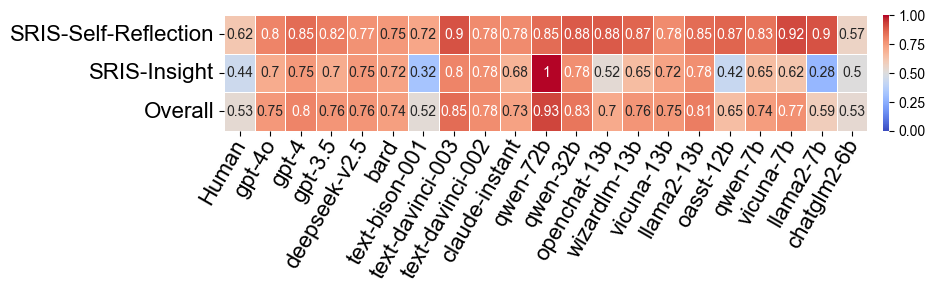

In [154]:
plt.figure(figsize=(10, 1.5))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

plt.rcParams['font.family'] = 'sans-serif'  # 选择一个好看的字体
plt.rcParams['font.sans-serif'] = ['Arial']  # 例如 Arial

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')

plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

plt.yticks(fontsize=16)
# plt.title('Psychology-Theoretical')
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'psy_the_orig.pdf'), bbox_inches='tight')
plt.show()

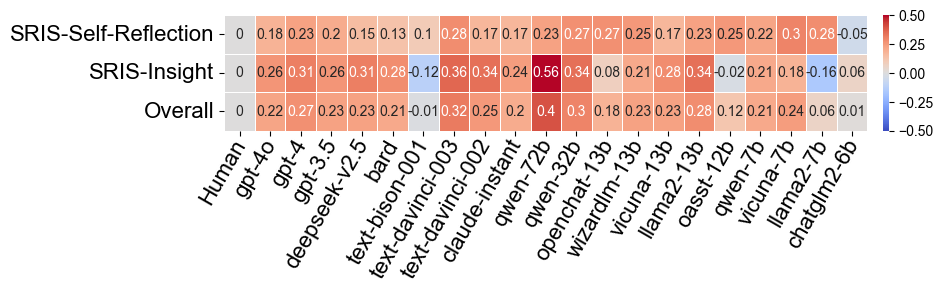

In [152]:
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
dfplot_2 = dfplot.copy()

plt.figure(figsize=(10, 1.5))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
# plt.title('Psychology-Theoretical')
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'psy_the_norm.pdf'), bbox_inches='tight')
plt.show()

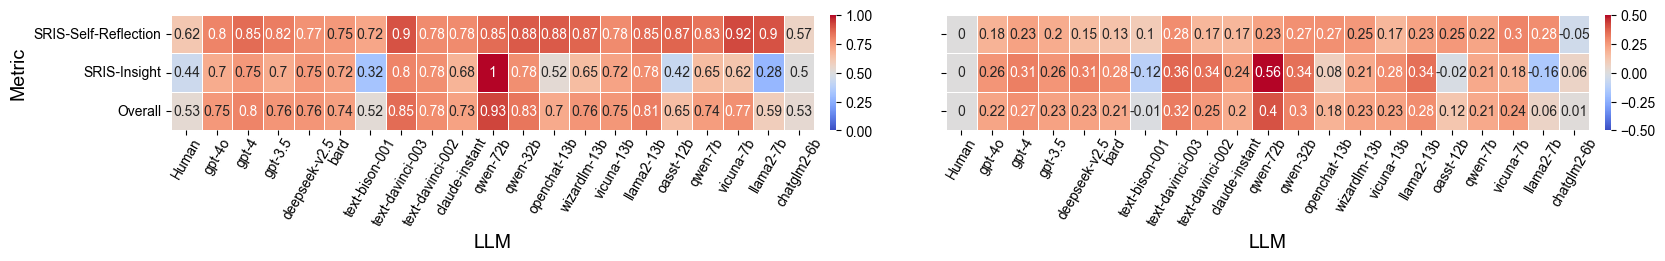

In [13]:

# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 创建一个1行2列的子图布局，并共享y轴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 1.5), sharey=True)

# # 在第一个子图上绘制dfplot的热力图
sns.heatmap(dfplot_1, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, 
            annot_kws={"size": 10}, ax=ax1, cbar_kws={"pad": 0.02})

# 设置x轴刻度标签并倾斜
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='center')
ax1.tick_params(axis='x', which='major', pad=0)
cbar_ax1 = ax1.collections[0].colorbar
cbar_ax1.ax.set_position([ax1.get_position().x1 + 1, ax1.get_position().y0, 0.92, ax1.get_position().height])

# 在第二个子图上绘制dfplot1的热力图
sns.heatmap(dfplot_2, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, 
            annot_kws={"size": 10}, ax=ax2, cbar_kws={"pad": 0.02})
# 设置x轴刻度标签并倾斜
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='center', fontsize=10)
ax2.tick_params(axis='x', which='major', pad=0)

# 设置标题和轴标签
# fig.suptitle('Psychology-Theoretical', y=1.15, fontsize=16)  # 调整标题的位置
ax1.set_ylabel('Metric', fontsize=14)
ax1.set_xlabel('LLM', fontsize=14)
ax2.set_xlabel('LLM', fontsize=14)
ax2.set_ylabel('')  # 移除右图的y轴标签

plt.subplots_adjust(wspace=-0.0)  # 减少子图之间的间距
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以适应标题
plt.savefig(os.path.join(plotpath, 'psy_the.pdf'), bbox_inches='tight')
plt.show()


## Psychology+Practical

In [155]:
selected_scales=['Emotion Regulation Questionnaire (ERQ)',
            'Need for Cognition',]
selected_elements=['Reappraisal Items','Suppression Items','Need for Cognition']

df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
# df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]
df1=df1[df1.apply(lambda x: x['Scale'] in selected_scales,axis=1)]
df1

Concepts                                   Scale  \
13    Emotion Regulation  Emotion Regulation Questionnaire (ERQ)   
16    Emotion Regulation  Emotion Regulation Questionnaire (ERQ)   
22  Intrinsic Motivation                      Need for Cognition   

               name     Scale Elements Higher score & Ratonality  \
13  ERQ-Reappraisal  Reappraisal Items       Support Rationality   
16  ERQ-Suppression  Suppression Items       Support Rationality   
22              NFC            Overall       Support Rationality   

   Total/Average/Level gpt-4 gpt-3.5 text-davinci-003 text-davinci-002  \
13       Average_score     6       6                7             6.33   
16       Average_score     3     2.5                6                5   
22       Average_score  3.94    4.33             4.67             3.78   

   claude-instant text-bison-001  bard chatglm2-6b llama2-13b llama2-7b  \
13           5.67           5.33  6.17        6.83       6.83      6.17   
16            2.5              5  3.25         2.5        1.5      3.75   
22           3.94           4.61  4.11        4.28       4.28         4   

   vicuna-13b vicuna-7b openchat-13b wizardlm-13b oasst-12b qwen-7b qwen-32b  \
13       6.83         6            6         6.67         5    6.67     6.33   
16       1.75      4.75         6.25          5.5      5.25       4      3.5   
22       3.94         4         3.83         3.72       3.5     4.5     4.94   

   qwen-72b gpt-4o deepseek-v2.5 Human  Max_score  Min_score  Show  
13     6.33   6.33             6   4.6        7.0        1.0     1  
16     4.25   3.75             4  3.46        7.0        1.0     1  
22     4.72   3.89          4.89  4.55        5.0        1.0     1

In [156]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot_1 = dfplot.copy()
dfplot

Human    gpt-4o     gpt-4   gpt-3.5  deepseek-v2.5  \
name                                                                   
ERQ-Reappraisal  0.6000  0.888333  0.833333  0.833333       0.833333   
ERQ-Suppression  0.4100  0.458333  0.333333  0.250000       0.500000   
NFC              0.8875  0.722500  0.735000  0.832500       0.972500   
Overall          0.6320  0.690000  0.634000  0.639000       0.769000   

                     bard  text-bison-001  text-davinci-003  text-davinci-002  \
name                                                                            
ERQ-Reappraisal  0.861667        0.721667          1.000000          0.888333   
ERQ-Suppression  0.375000        0.666667          0.833333          0.666667   
NFC              0.777500        0.902500          0.917500          0.695000   
Overall          0.671000        0.764000          0.917000          0.750000   

                 claude-instant  qwen-72b  qwen-32b  openchat-13b  \
name                                                                
ERQ-Reappraisal        0.778333  0.888333  0.888333      0.833333   
ERQ-Suppression        0.250000  0.541667  0.416667      0.875000   
NFC                    0.735000  0.930000  0.985000      0.707500   
Overall                0.588000  0.787000  0.763000      0.805000   

                 wizardlm-13b  vicuna-13b  llama2-13b  oasst-12b  qwen-7b  \
name                                                                        
ERQ-Reappraisal         0.945    0.971667    0.971667   0.666667    0.945   
ERQ-Suppression         0.750    0.125000    0.083333   0.708333    0.500   
NFC                     0.680    0.735000    0.820000   0.625000    0.875   
Overall                 0.792    0.611000    0.625000   0.667000    0.773   

                 vicuna-7b  llama2-7b  chatglm2-6b  
name                                                
ERQ-Reappraisal   0.833333   0.861667     0.971667  
ERQ-Suppression   0.625000   0.458333     0.250000  
NFC               0.750000   0.750000     0.820000  
Overall           0.736000   0.690000     0.681000

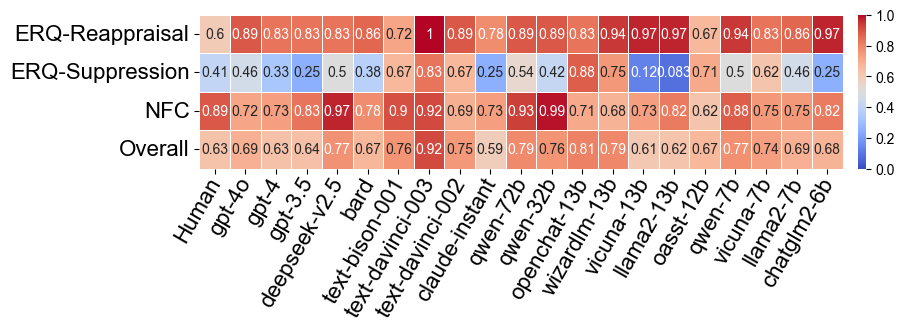

In [157]:
plt.figure(figsize=(10, 2))
heatmap=sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')
plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'psy_pra_orig.pdf'), bbox_inches='tight')
plt.show()

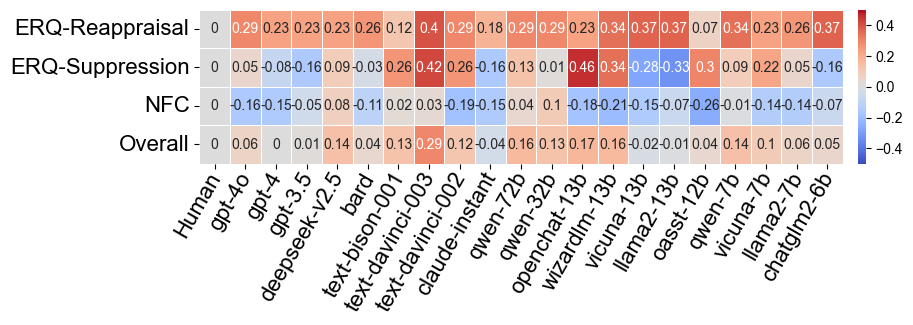

In [158]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
dfplot_2 = dfplot.copy()
# dfplot

plt.figure(figsize=(10, 2))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'psy_pra_norm.pdf'), bbox_inches='tight')
plt.show()

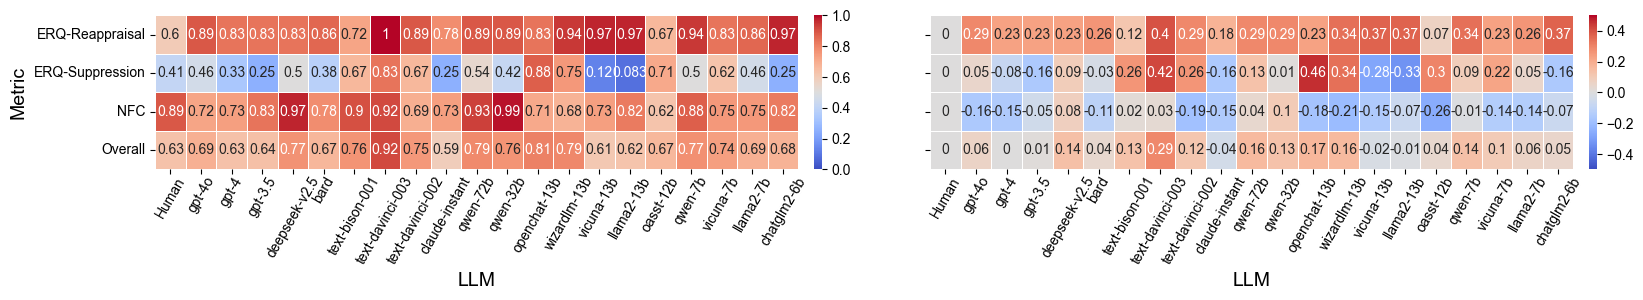

In [18]:

# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 创建一个1行2列的子图布局，并共享y轴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 2), sharey=True)

# # 在第一个子图上绘制dfplot的热力图
sns.heatmap(dfplot_1, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, 
            annot_kws={"size": 10}, ax=ax1, cbar_kws={"pad": 0.02})
# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot_1.columns))):
#     if j == 0:
#         ax1.add_patch(plt.Rectangle((j, 0), 1, len(dfplot_1.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = ax1.get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')

# 设置x轴刻度标签并倾斜
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='center')
ax1.tick_params(axis='x', which='major', pad=0)
cbar_ax1 = ax1.collections[0].colorbar
cbar_ax1.ax.set_position([ax1.get_position().x1 + 1, ax1.get_position().y0, 0.92, ax1.get_position().height])

# 在第二个子图上绘制dfplot1的热力图
sns.heatmap(dfplot_2, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, 
            annot_kws={"size": 10}, ax=ax2, cbar_kws={"pad": 0.02})
# 设置x轴刻度标签并倾斜
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='center')
ax2.tick_params(axis='x', which='major', pad=0)

# 设置标题和轴标签
# fig.suptitle('Psychology-Practical', y=1.05, fontsize=16)  # 调整标题的位置
ax1.set_ylabel('Metric', fontsize=14)
ax1.set_xlabel('LLM', fontsize=14)
ax2.set_xlabel('LLM', fontsize=14)
ax2.set_ylabel('')  # 移除右图的y轴标签

plt.subplots_adjust(wspace=-0.0)  # 减少子图之间的间距
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以适应标题
plt.savefig(os.path.join(plotpath, 'psy_pra.pdf'), bbox_inches='tight')
plt.show()


## Psychology+Overall

In [37]:
selected_scales=['self reflection and insight scale (SRIS)',]
selected_elements=['Self-reflection','Insight',]

selected_scales.extend(['Emotion Regulation Questionnaire (ERQ)',
            'Need for Cognition',])
selected_elements.extend(['Reappraisal Items','Suppression Items','Overall'])

df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x:x['Scale'] in selected_scales,axis=1)]
df1

Concepts                                     Scale  \
7        Self-Reflection  self reflection and insight scale (SRIS)   
10       Self-Reflection  self reflection and insight scale (SRIS)   
13    Emotion Regulation    Emotion Regulation Questionnaire (ERQ)   
16    Emotion Regulation    Emotion Regulation Questionnaire (ERQ)   
22  Intrinsic Motivation                        Need for Cognition   

                    name     Scale Elements Higher score & Ratonality  \
7   SRIS-Self-Reflection    Self-reflection       Support Rationality   
10          SRIS-Insight            Insight       Support Rationality   
13       ERQ-Reappraisal  Reappraisal Items       Support Rationality   
16       ERQ-Suppression  Suppression Items       Support Rationality   
22                   NFC            Overall       Support Rationality   

   Total/Average/Level gpt-4 gpt-3.5 text-davinci-003 text-davinci-002  \
7        Average_score  5.25    5.08              5.5             4.92   
10       Average_score  4.75     4.5                5             4.88   
13       Average_score     6       6                7             6.33   
16       Average_score     3     2.5                6                5   
22       Average_score  3.94    4.33             4.67             3.78   

   claude-instant text-bison-001  bard chatglm2-6b llama2-13b llama2-7b  \
7            4.92           4.58  4.75        3.83       5.25       5.5   
10           4.38           2.62  4.62         3.5       4.88      2.38   
13           5.67           5.33  6.17        6.83       6.83      6.17   
16            2.5              5  3.25         2.5        1.5      3.75   
22           3.94           4.61  4.11        4.28       4.28         4   

   vicuna-13b vicuna-7b openchat-13b wizardlm-13b oasst-12b qwen-7b qwen-32b  \
7        4.92      5.58         5.42         5.33      5.33    5.17     5.42   
10       4.62      4.12         3.62         4.25      3.12    4.25     4.88   
13       6.83         6            6         6.67         5    6.67     6.33   
16       1.75      4.75         6.25          5.5      5.25       4      3.5   
22       3.94         4         3.83         3.72       3.5     4.5     4.94   

   qwen-72b gpt-4o deepseek-v2.5 Human  Max_score  Min_score  Show  
7      5.25      5          4.83  4.08        6.0        1.0     1  
10        6    4.5          4.75   3.2        6.0        1.0     1  
13     6.33   6.33             6   4.6        7.0        1.0     1  
16     4.25   3.75             4  3.46        7.0        1.0     1  
22     4.72   3.89          4.89  4.55        5.0        1.0     1

In [38]:
df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot

Human    gpt-4o  \
name                                                                   
self reflection and insight scale (SRIS)\nSelf-...  0.6160  0.800000   
self reflection and insight scale (SRIS)\nInsight   0.4400  0.700000   
Emotion Regulation Questionnaire (ERQ)\nReappra...  0.6000  0.888333   
Emotion Regulation Questionnaire (ERQ)\nSuppres...  0.4100  0.458333   
Need for Cognition\nOverall                         0.8875  0.722500   
Overall                                             0.5910  0.714000   

                                                       gpt-4   gpt-3.5  \
name                                                                     
self reflection and insight scale (SRIS)\nSelf-...  0.850000  0.816000   
self reflection and insight scale (SRIS)\nInsight   0.750000  0.700000   
Emotion Regulation Questionnaire (ERQ)\nReappra...  0.833333  0.833333   
Emotion Regulation Questionnaire (ERQ)\nSuppres...  0.333333  0.250000   
Need for Cognition\nOverall                         0.735000  0.832500   
Overall                                             0.700000  0.686000   

                                                    deepseek-v2.5      bard  \
name                                                                          
self reflection and insight scale (SRIS)\nSelf-...       0.766000  0.750000   
self reflection and insight scale (SRIS)\nInsight        0.750000  0.724000   
Emotion Regulation Questionnaire (ERQ)\nReappra...       0.833333  0.861667   
Emotion Regulation Questionnaire (ERQ)\nSuppres...       0.500000  0.375000   
Need for Cognition\nOverall                              0.972500  0.777500   
Overall                                                  0.764000  0.698000   

                                                    text-bison-001  \
name                                                                 
self reflection and insight scale (SRIS)\nSelf-...        0.716000   
self reflection and insight scale (SRIS)\nInsight         0.324000   
Emotion Regulation Questionnaire (ERQ)\nReappra...        0.721667   
Emotion Regulation Questionnaire (ERQ)\nSuppres...        0.666667   
Need for Cognition\nOverall                               0.902500   
Overall                                                   0.666000   

                                                    text-davinci-003  \
name                                                                   
self reflection and insight scale (SRIS)\nSelf-...          0.900000   
self reflection and insight scale (SRIS)\nInsight           0.800000   
Emotion Regulation Questionnaire (ERQ)\nReappra...          1.000000   
Emotion Regulation Questionnaire (ERQ)\nSuppres...          0.833333   
Need for Cognition\nOverall                                 0.917500   
Overall                                                     0.890000   

                                                    text-davinci-002  \
name                                                                   
self reflection and insight scale (SRIS)\nSelf-...          0.784000   
self reflection and insight scale (SRIS)\nInsight           0.776000   
Emotion Regulation Questionnaire (ERQ)\nReappra...          0.888333   
Emotion Regulation Questionnaire (ERQ)\nSuppres...          0.666667   
Need for Cognition\nOverall                                 0.695000   
Overall                                                     0.762000   

                                                    claude-instant  qwen-72b  \
name                                                                           
self reflection and insight scale (SRIS)\nSelf-...        0.784000  0.850000   
self reflection and insight scale (SRIS)\nInsight         0.676000  1.000000   
Emotion Regulation Questionnaire (ERQ)\nReappra...        0.778333  0.888333   
Emotion Regulation Questionnaire (ERQ)\nSuppres...        0.250000  0.541667   
Need for Cognition\nOverall                            

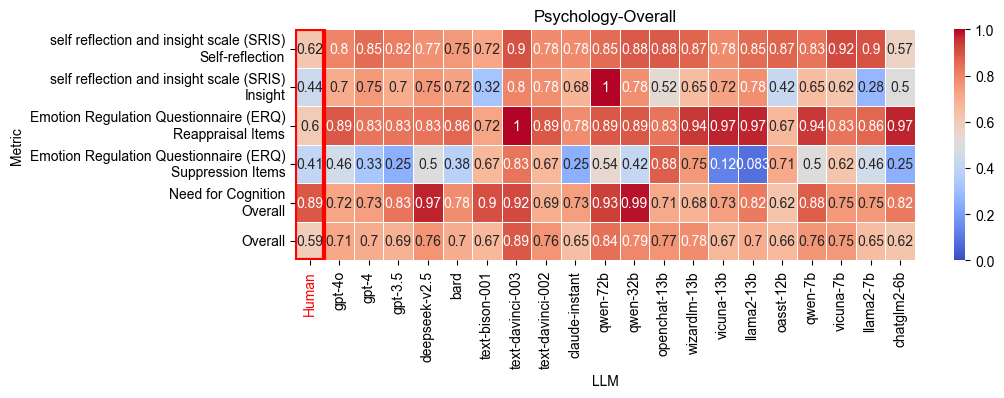

In [21]:
plt.figure(figsize=(10, 3))
heatmap=sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1)

# 添加红色边框在第一列
for _, j in enumerate(range(len(dfplot.columns))):
    if j == 0:  # 检查是否是1st列
        plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# 将第一列的x轴刻度标签设置为红色
xticks_labels = plt.gca().get_xticklabels()
if xticks_labels:
    xticks_labels[0].set_color('red')
    
plt.title('Psychology-Overall')
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()

## Cognitive and Behavioral Sciences+Theoretical

In [159]:
selected_scales=['Rationality-Experimental Inventory (REI)',
            'Cognitive Reflection Test',
            'Letter Sets Test',
                 'Logiqa 2.0',
                 'Causal Reasoning',
                 'Wason Selection Task',
                 'Defeasible Reasoning',
            'Scientific Reasoning Scale',
            'Critical Thinking Disposition Scale',
                 'Actively Open-Minded Thinking Scale'
                ]
# selected_elements=['Rationality (overall)','Experimentality (overall)','Rational answer','Overall','overall',
#             'odd','even']

# df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]
df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x: x['Scale'] in selected_scales,axis=1)]
# df1

In [160]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot_1 = dfplot.copy()
dfplot

Human    gpt-4o     gpt-4   gpt-3.5  deepseek-v2.5  \
name                                                                          
REI-Rationality       0.597500  0.862500  0.800000  0.712500       0.787500   
REI-Experimentality   0.370000  0.275000  1.000000  0.300000       0.000000   
CRT                   0.210000  1.000000  1.000000  0.860000       1.000000   
Letter Sets Test      0.640000  0.500000  0.700000  0.400000       0.500000   
Logiqa                0.840000  0.690000  0.700000  0.500000       0.650000   
Causal Reasoning      0.915294  0.774118  0.792941  0.647059       0.708235   
Scientific Reasoning  0.620000  1.000000  0.910000  0.450000       1.000000   
Defeasible Reasoning  0.555000  0.500000  0.166667  0.166667       0.666667   
WST-Abstract          0.190000  0.330000  0.000000  0.000000       0.670000   
WST-Deontic           0.440000  1.000000  0.670000  0.670000       1.000000   
CTDS                  0.722500  0.795000  0.817500  0.887500       0.840000   
AOT                   0.724000  0.706000  0.654000  0.706000       0.586000   
Overall               0.569000  0.703000  0.684000  0.525000       0.701000   

                          bard  text-bison-001  text-davinci-003  \
name                                                               
REI-Rationality       0.637500        0.875000          0.812500   
REI-Experimentality   0.437500        0.287500          0.087500   
CRT                   0.860000        0.290000          0.140000   
Letter Sets Test      0.330000        0.230000          0.370000   
Logiqa                0.580000        0.500000          0.500000   
Causal Reasoning      0.807059        0.703529          0.783529   
Scientific Reasoning  0.820000        0.820000          0.730000   
Defeasible Reasoning  0.333333        0.333333          0.000000   
WST-Abstract          0.000000        0.000000          0.000000   
WST-Deontic           0.670000        0.330000          0.330000   
CTDS                  0.840000        0.750000          0.887500   
AOT                   0.640000        0.360000          0.720000   
Overall               0.580000        0.457000          0.447000   

                      text-davinci-002  claude-instant  qwen-72b  qwen-32b  \
name                                                                         
REI-Rationality               0.700000        0.675000  0.975000  1.000000   
REI-Experimentality           0.287500        0.337500  0.237500  0.262500   
CRT                           0.140000        0.430000  0.860000  1.000000   
Letter Sets Test              0.300000        0.300000  0.630000  0.570000   
Logiqa                        0.600000        0.470000  0.770000  0.720000   
Causal Reasoning              0.698824        0.689412  0.750588  0.736471   
Scientific Reasoning          0.730000        0.640000  1.000000  0.910000   
Defeasible Reasoning          0.333333        0.166667  0.333333  0.166667   
WST-Abstract                  0.000000        0.670000  0.330000  0.330000   
WST-Deontic                   0.330000        0.000000  1.000000  1.000000   
CTDS                          0.772500        0.795000  0.955000  0.862500   
AOT                           0.654000        0.560000  0.734000  0.706000   
Overall                       0.462000        0.478000  0.715000  0.689000   

                      openchat-13b  wizardlm-13b  vicuna-13b  llama2-13b  \
name                                                                       
REI-Rationality           0.650000      0.662500    0.750000    0.912500   
REI-Experimentality       0.287500      0.362500    0.050000    0.162500   
CRT                       0.140000      0.140000    0.140000    0.140000   
Letter Sets Test          0.370000      0.300000    0.230000    0.270000   
Logiqa                    0.580000      0.420000    0.300000    0.530000   
Causal Reasoning          0.689412      0.661176    0.595294    0.745882   
Scientific Reasoning      0.640000     

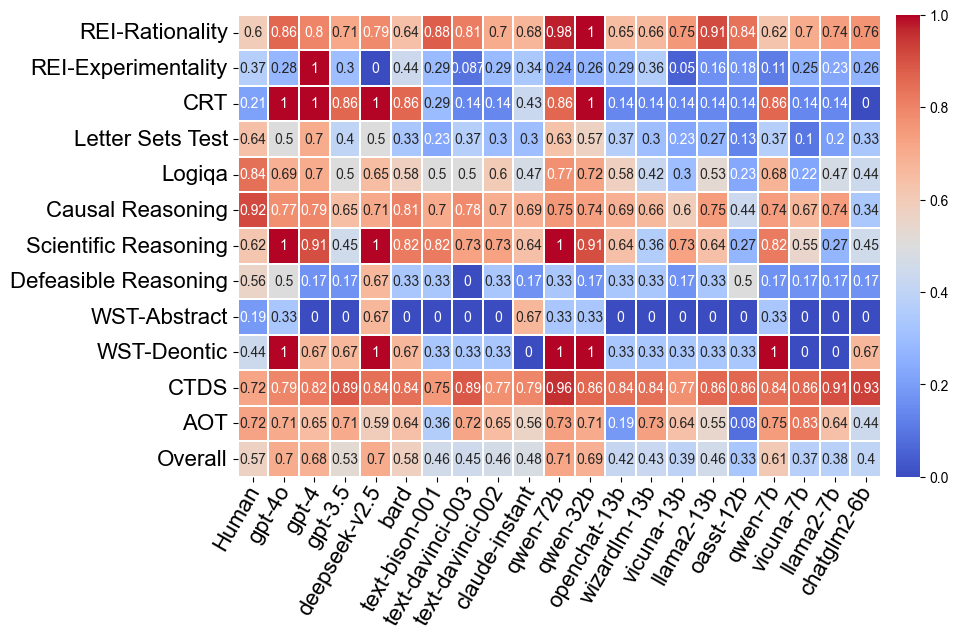

In [161]:
plt.figure(figsize=(10, 6))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.1, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')
plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'cog_the_orig.pdf'), bbox_inches='tight')
plt.show()

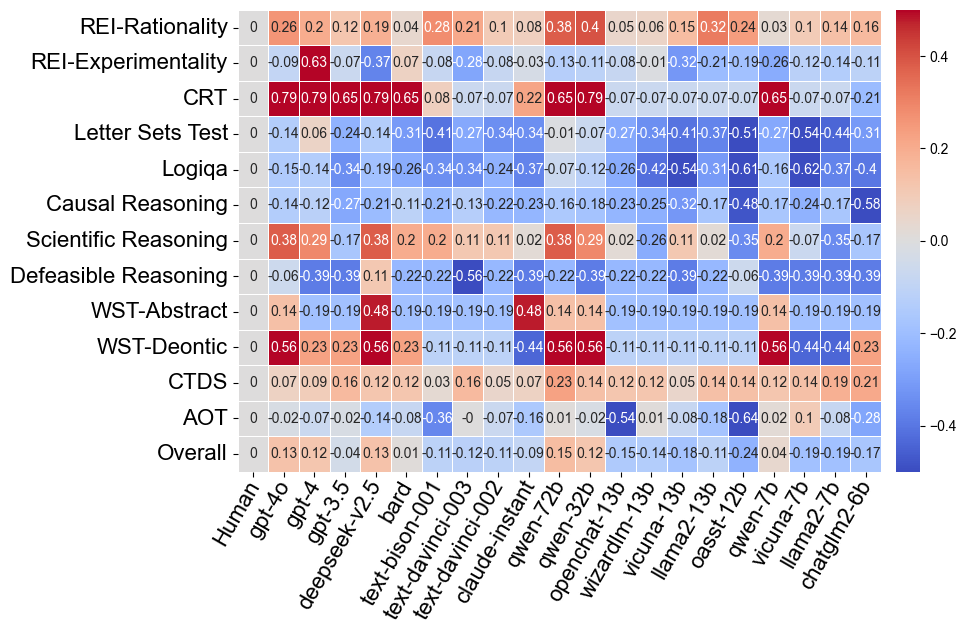

In [162]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
dfplot_2 = dfplot.copy()

plt.figure(figsize=(10, 6))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'cog_the_norm.pdf'), bbox_inches='tight')
plt.show()

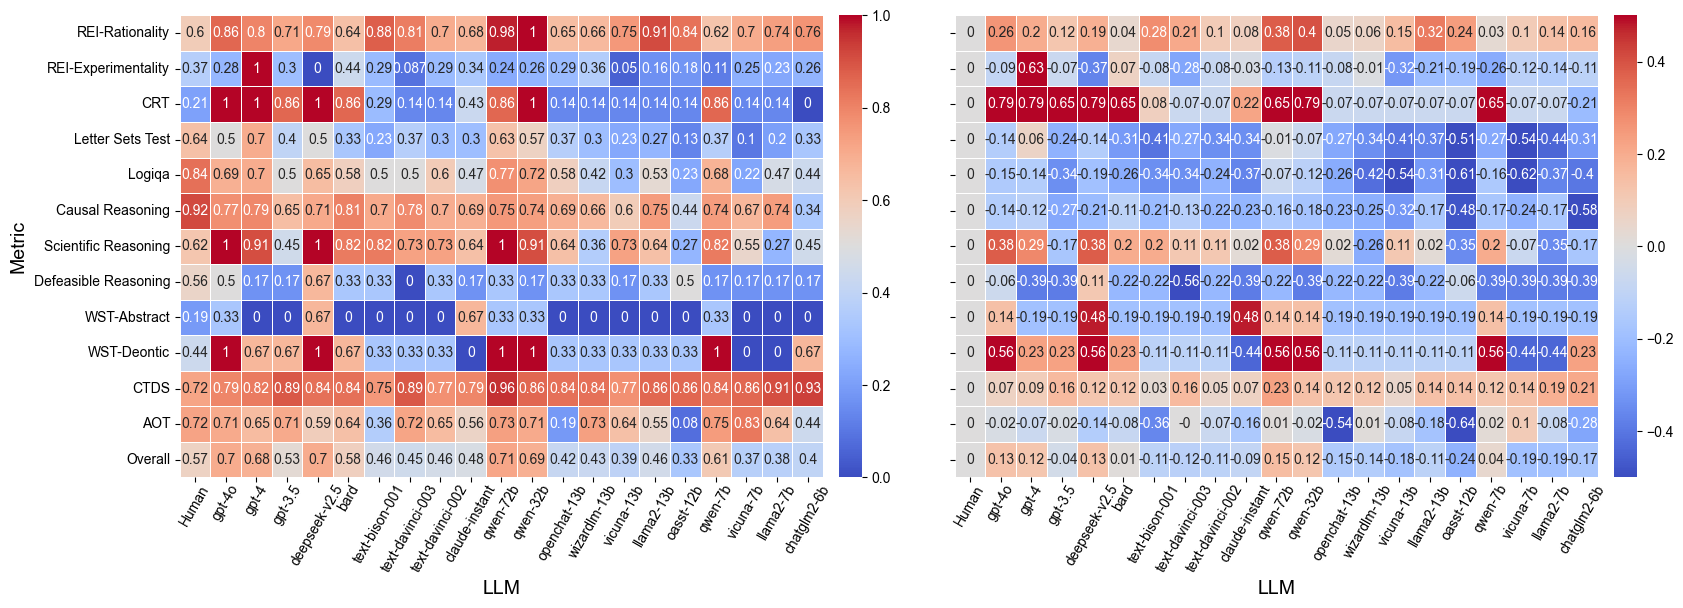

In [26]:

# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 创建一个1行2列的子图布局，并共享y轴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# # 在第一个子图上绘制dfplot的热力图
sns.heatmap(dfplot_1, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, 
            annot_kws={"size": 10}, ax=ax1, cbar_kws={"pad": 0.02})
# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot_1.columns))):
#     if j == 0:
#         ax1.add_patch(plt.Rectangle((j, 0), 1, len(dfplot_1.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = ax1.get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')

# 设置x轴刻度标签并倾斜
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='center')
ax1.tick_params(axis='x', which='major', pad=0)
cbar_ax1 = ax1.collections[0].colorbar
cbar_ax1.ax.set_position([ax1.get_position().x1 + 1, ax1.get_position().y0, 0.92, ax1.get_position().height])

# 在第二个子图上绘制dfplot1的热力图
sns.heatmap(dfplot_2, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, 
            annot_kws={"size": 10}, ax=ax2, cbar_kws={"pad": 0.02})
# 设置x轴刻度标签并倾斜
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='center')
ax2.tick_params(axis='x', which='major', pad=0)

# 设置标题和轴标签
# fig.suptitle('Cognitive and Behavioral Sciences-Theoretical', y=0.95, fontsize=16)  # 调整标题的位置
ax1.set_ylabel('Metric', fontsize=14)
ax1.set_xlabel('LLM', fontsize=14)
ax2.set_xlabel('LLM', fontsize=14)
ax2.set_ylabel('')  # 移除右图的y轴标签

plt.subplots_adjust(wspace=-0.0)  # 减少子图之间的间距
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以适应标题
plt.savefig(os.path.join(plotpath, 'cog_the.pdf'), bbox_inches='tight')
plt.show()


## Cognitive and Behavioral Sciences+Practical

In [163]:
selected_scales=['Belief Bias in Syllogistic Reasoning',
                 'Bias Blind Spot',
                 'Hindsight Bias',
                 'Illusion of Control',
                
                'Regret Aversion']
selected_elements=['Outcome bias','Regret Aversion']

df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x:x['Scale'] in selected_scales,axis=1)]
df1

Concepts                                 Scale  \
101  Heuristics and Biases  Belief Bias in Syllogistic Reasoning   
102  Heuristics and Biases                       Bias Blind Spot   
103  Heuristics and Biases                        Hindsight Bias   
104  Heuristics and Biases                   Illusion of Control   
106  Heuristics and Biases                       Regret Aversion   

                    name Scale Elements Higher score & Ratonality  \
101          Belief Bias        Overall        Oppose Rationality   
102      Bias Blind Spot        Overall        Oppose Rationality   
103       Hindsight Bias        Overall        Oppose Rationality   
104  Illusion of Control        Overall        Oppose Rationality   
106      Regret Aversion        Overall        Oppose Rationality   

    Total/Average/Level gpt-4 gpt-3.5 text-davinci-003 text-davinci-002  \
101         Total_score     3       3                3                3   
102         Total_score     2    1.29             3.29             1.29   
103         Total_score     1       2                2                2   
104         Total_score     0       2                1                1   
106         Total_score     1       1                1                0   

    claude-instant text-bison-001  bard chatglm2-6b llama2-13b llama2-7b  \
101              2              3     1           0          2         1   
102           0.79           1.86  0.21        0.71       1.14      2.36   
103              2              1     1           2          1         2   
104              0              2     0           2          1         2   
106              1              1     1           2          1         2   

    vicuna-13b vicuna-7b openchat-13b wizardlm-13b oasst-12b qwen-7b qwen-32b  \
101          2         0            3            1         0       0        2   
102       0.29      0.64         1.79         0.71     -0.29    0.57     3.57   
103          1         2            2            1         3       1        1   
104          1         2            1            2         2       1        0   
106          1         2            1            1         2       1        1   

    qwen-72b gpt-4o deepseek-v2.5 Human  Max_score  Min_score  Show  
101        2      2             2   1.5        4.0        0.0     1  
102     2.29   2.21          1.07  1.48        6.0        0.0     1  
103        1      1             1   1.6        4.0        1.0     1  
104        0      1             2  0.82        2.0        0.0     1  
106        1      1             1  2.01        3.0        0.0     1

In [164]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot_1=dfplot.copy()
dfplot

Human    gpt-4o     gpt-4   gpt-3.5  deepseek-v2.5  \
name                                                                         
Belief Bias          0.625000  0.500000  0.250000  0.250000       0.500000   
Bias Blind Spot      0.753333  0.631667  0.666667  0.785000       0.821667   
Hindsight Bias       0.800000  1.000000  1.000000  0.666667       1.000000   
Illusion of Control  0.590000  0.500000  1.000000  0.000000       0.000000   
Regret Aversion      0.330000  0.666667  0.666667  0.666667       0.666667   
Overall              0.620000  0.660000  0.717000  0.474000       0.598000   

                         bard  text-bison-001  text-davinci-003  \
name                                                              
Belief Bias          0.750000        0.250000          0.250000   
Bias Blind Spot      0.965000        0.690000          0.451667   
Hindsight Bias       1.000000        1.000000          0.666667   
Illusion of Control  1.000000        0.000000          0.500000   
Regret Aversion      0.666667        0.666667          0.666667   
Overall              0.876000        0.521000          0.507000   

                     text-davinci-002  claude-instant  qwen-72b  qwen-32b  \
name                                                                        
Belief Bias                  0.250000        0.500000  0.500000  0.500000   
Bias Blind Spot              0.785000        0.868333  0.618333  0.405000   
Hindsight Bias               0.666667        0.666667  1.000000  1.000000   
Illusion of Control          0.500000        1.000000  1.000000  1.000000   
Regret Aversion              1.000000        0.666667  0.666667  0.666667   
Overall                      0.640000        0.740000  0.757000  0.714000   

                     openchat-13b  wizardlm-13b  vicuna-13b  llama2-13b  \
name                                                                      
Belief Bias              0.250000      0.750000    0.500000    0.500000   
Bias Blind Spot          0.701667      0.881667    0.951667    0.810000   
Hindsight Bias           0.666667      1.000000    1.000000    1.000000   
Illusion of Control      0.500000      0.000000    0.500000    0.500000   
Regret Aversion          0.666667      0.666667    0.666667    0.666667   
Overall                  0.557000      0.660000    0.724000    0.695000   

                     oasst-12b   qwen-7b  vicuna-7b  llama2-7b  chatglm2-6b  
name                                                                         
Belief Bias           1.000000  1.000000   1.000000   0.750000     1.000000  
Bias Blind Spot       1.048333  0.905000   0.893333   0.606667     0.881667  
Hindsight Bias        0.333333  1.000000   0.666667   0.666667     0.666667  
Illusion of Control   0.000000  0.500000   0.000000   0.000000     0.000000  
Regret Aversion       0.333333  0.666667   0.333333   0.333333     0.333333  
Overall               0.543000  0.814000   0.579000   0.471000     0.576000

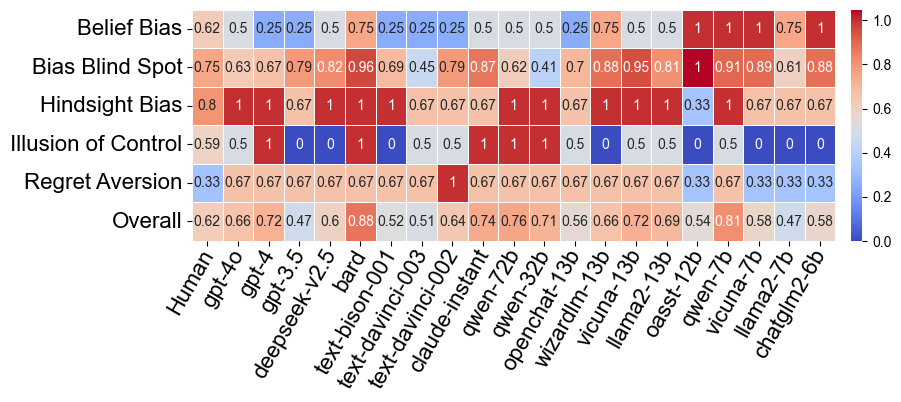

In [165]:
plt.figure(figsize=(10, 3))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')
plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'cog_pra_orig.pdf'), bbox_inches='tight')
plt.show()

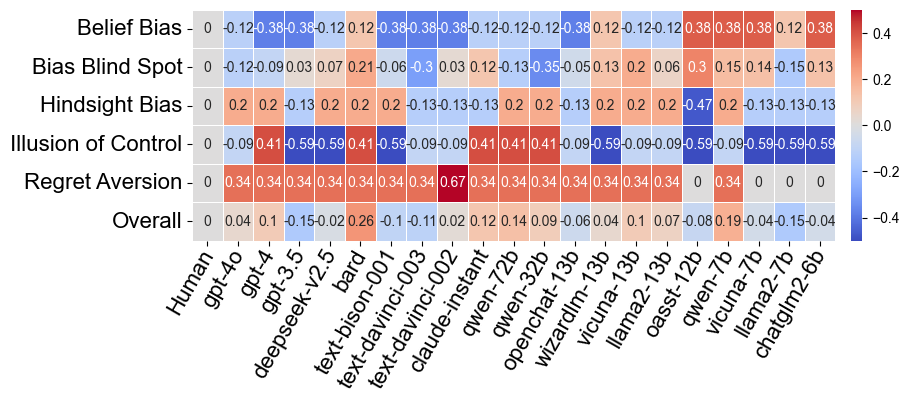

In [166]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
dfplot_2 = dfplot.copy()

plt.figure(figsize=(10, 3))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'cog_pra_norm.pdf'), bbox_inches='tight')
plt.show()

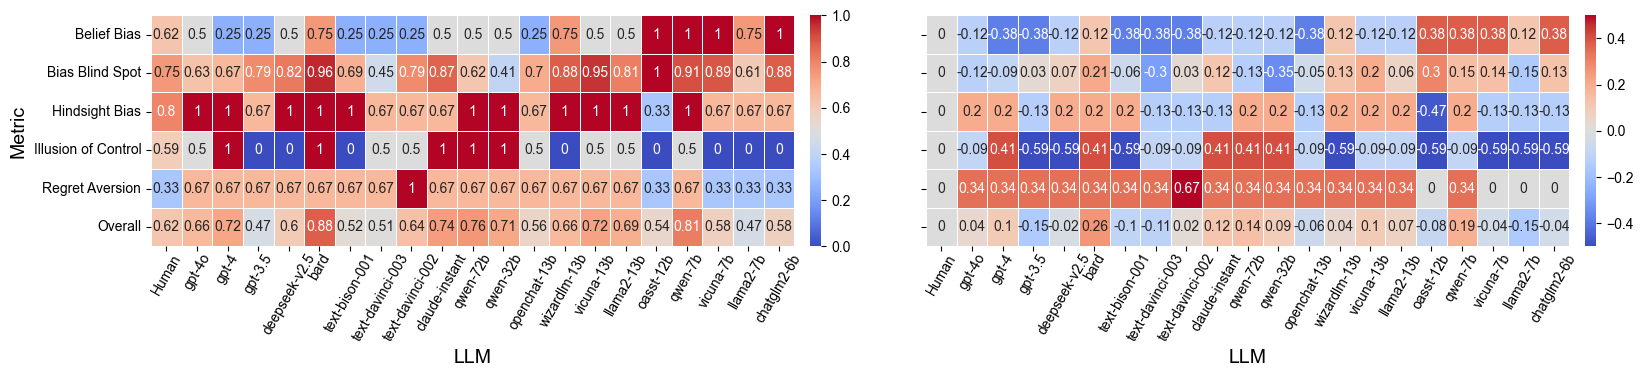

In [31]:

# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 创建一个1行2列的子图布局，并共享y轴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3), sharey=True)

# # 在第一个子图上绘制dfplot的热力图
sns.heatmap(dfplot_1, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, 
            annot_kws={"size": 10}, ax=ax1, cbar_kws={"pad": 0.02})
# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot_1.columns))):
#     if j == 0:
#         ax1.add_patch(plt.Rectangle((j, 0), 1, len(dfplot_1.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = ax1.get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')

# 设置x轴刻度标签并倾斜
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='center')
ax1.tick_params(axis='x', which='major', pad=0)
cbar_ax1 = ax1.collections[0].colorbar
cbar_ax1.ax.set_position([ax1.get_position().x1 + 1, ax1.get_position().y0, 0.92, ax1.get_position().height])

# 在第二个子图上绘制dfplot1的热力图
sns.heatmap(dfplot_2, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, 
            annot_kws={"size": 10}, ax=ax2, cbar_kws={"pad": 0.02})
# 设置x轴刻度标签并倾斜
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='center')
ax2.tick_params(axis='x', which='major', pad=0)

# 设置标题和轴标签
# fig.suptitle('Cognitive and Behavioral Sciences-Practical', y=1.0, fontsize=16)  # 调整标题的位置
ax1.set_ylabel('Metric', fontsize=14)
ax1.set_xlabel('LLM', fontsize=14)
ax2.set_xlabel('LLM', fontsize=14)
ax2.set_ylabel('')  # 移除右图的y轴标签

plt.subplots_adjust(wspace=-0.0)  # 减少子图之间的间距
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以适应标题
plt.savefig(os.path.join(plotpath, 'cog_pra.pdf'), bbox_inches='tight')
plt.show()


## Cognitive and Behavioral Sciences+Overall

In [43]:
selected_scales=['Rationality-Experimental Inventory (REI)',
            'Cognitive Reflection Test',
            'Letter Sets Test',
                 'Logiqa 2.0',
                 'Causal Reasoning Test on LLM',
                 'Wason Selection Task',
                 'Defeasible Reasoning',
            'Scientific Reasoning Scale',
            'Critical Thinking Disposition Scale',
                 'Actively Open-Minded Thinking Scale'
                ]

tmp=['Belief Bias in Syllogistic Reasoning',
                 'Bias Blind Spot',
                 'Hindsight Bias',
                 'Illusion of Control',
                'Regret Aversion']
selected_scales.extend(tmp)


# df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]
df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x: x['Scale'] in selected_scales,axis=1)]
# df1

In [44]:
df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot

Human    gpt-4o  \
name                                                                     
Rationality-Experimental Inventory (REI)\nRatio...  0.597500  0.862500   
Rationality-Experimental Inventory (REI)\nExper...  0.370000  0.275000   
Cognitive Reflection Test\nRational answer          0.210000  1.000000   
Letter Sets Test\nOverall                           0.640000  0.500000   
Logiqa 2.0\nOverall                                 0.840000  0.690000   
Scientific Reasoning Scale\nOverall                 0.620000  1.000000   
Defeasible Reasoning\nOverall                       0.555000  0.500000   
Wason Selection Task\nOdd                           0.190000  0.330000   
Wason Selection Task\nEven                          0.440000  1.000000   
Critical Thinking Disposition Scale\nOverall        0.722500  0.795000   
Actively Open-Minded Thinking Scale\nOverall        0.724000  0.706000   
Belief Bias in Syllogistic Reasoning\nOverall       0.625000  0.500000   
Bias Blind Spot\nOverall                            0.753333  0.631667   
Hindsight Bias\nOverall                             0.800000  1.000000   
Illusion of Control\nOverall                        0.590000  0.500000   
Regret Aversion\nOverall                            0.330000  0.666667   
Overall                                             0.563000  0.685000   

                                                       gpt-4   gpt-3.5  \
name                                                                     
Rationality-Experimental Inventory (REI)\nRatio...  0.800000  0.712500   
Rationality-Experimental Inventory (REI)\nExper...  1.000000  0.300000   
Cognitive Reflection Test\nRational answer          1.000000  0.860000   
Letter Sets Test\nOverall                           0.700000  0.400000   
Logiqa 2.0\nOverall                                 0.700000  0.500000   
Scientific Reasoning Scale\nOverall                 0.910000  0.450000   
Defeasible Reasoning\nOverall                       0.166667  0.166667   
Wason Selection Task\nOdd                           0.000000  0.000000   
Wason Selection Task\nEven                          0.670000  0.670000   
Critical Thinking Disposition Scale\nOverall        0.817500  0.887500   
Actively Open-Minded Thinking Scale\nOverall        0.654000  0.706000   
Belief Bias in Syllogistic Reasoning\nOverall       0.250000  0.250000   
Bias Blind Spot\nOverall                            0.666667  0.785000   
Hindsight Bias\nOverall                             1.000000  0.666667   
Illusion of Control\nOverall                        1.000000  0.000000   
Regret Aversion\nOverall                            0.666667  0.666667   
Overall                                             0.688000  0.501000   

                                                    deepseek-v2.5      bard  \
name                                                                          
Rationality-Experimental Inventory (REI)\nRatio...       0.787500  0.637500   
Rationality-Experimental Inventory (REI)\nExper...       0.000000  0.437500   
Cognitive Reflection Test\nRational answer               1.000000  0.860000   
Letter Sets Test\nOverall                                0.500000  0.330000   
Logiqa 2.0\nOverall                                      0.650000  0.580000   
Scientific Reasoning Scale\nOverall                      1.000000  0.820000   
Defeasible Reasoning\nOverall                            0.666667  0.333333   
Wason Selection Task\nOdd                                0.670000  0.000000   
Wason Selection Task\nEven                               1.000000  0.670000   
Critical Thinking Disposition Scale\nOverall             0.840000  0.840000   
Actively Open-Minded Thinking Scale\nOverall             0.586000  0.640000   
Belief Bias in Syllogistic Reasoning\nOverall            0.500000  0.750000   
Bias Blind Spot\nOverall                                 0.821667  0.965000   
Hindsight Bias\nOverall                                 

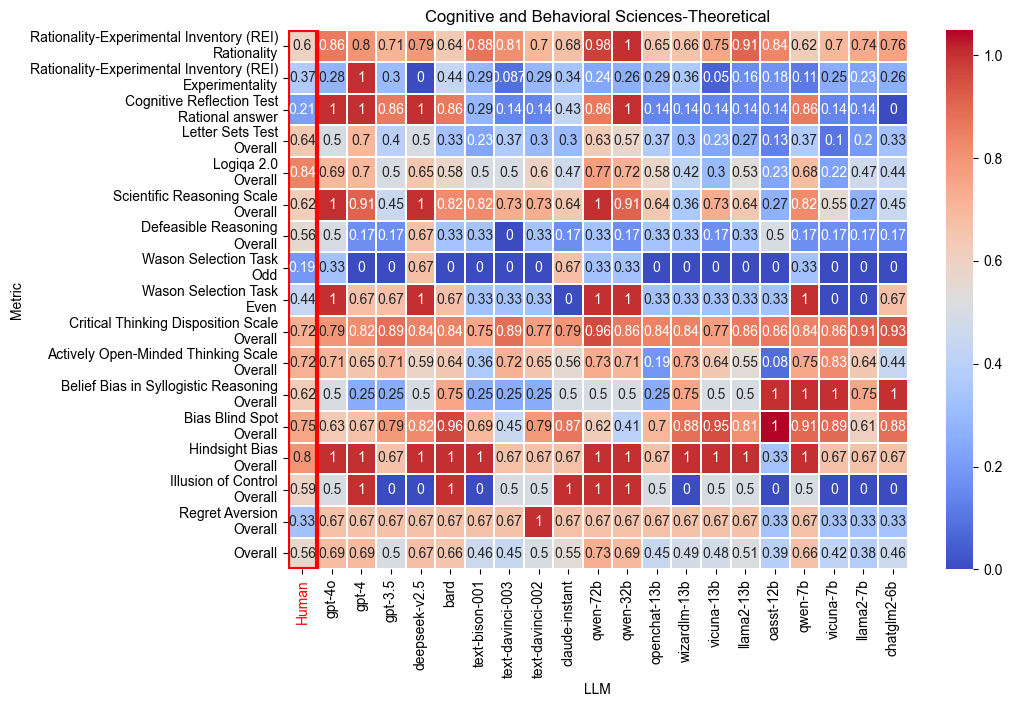

In [45]:
plt.figure(figsize=(10, 7))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.1)

# 添加红色边框在第一列
for _, j in enumerate(range(len(dfplot.columns))):
    if j == 0:  # 检查是否是1st列
        plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# 将第一列的x轴刻度标签设置为红色
xticks_labels = plt.gca().get_xticklabels()
if xticks_labels:
    xticks_labels[0].set_color('red')
        
plt.title('Cognitive and Behavioral Sciences-Theoretical')
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()

## Decision Making & Practical

In [167]:
selected_scales=['General Decision-Making Style',
            'Availability Heuristics',
            'Base-Rate Neglect (Statistical)',
            'Base-Rate Neglect (Causal)',
                 'Better-Than-Average Effect',
                 'Confirmation Bias',
            'Conjunction Fallacy',
                 'Covariation Detection',
                 'Denominator Neglect (or Ratio Bias)',
            'Framing Effect (Risk and Attribute)',
            'Probabilistic Matching',
                'Outcome bias',]

selected_elements=['Rational','Avoidant','Dependent','Intuitive','Spontaneous',
            'Availability Heuristics',
            'Base-Rate Neglect (Statistical)',
                   'Base-Rate Neglect (Causal)',
                   'Conjunction Fallacy','Overall',
                   'Probabilistic Matching',
                  ]

df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x:x['Scale'] in selected_scales,axis=1)]
df1

Concepts                                Scale  \
84   Decision-Making Style        General Decision-Making Style   
87   Decision-Making Style        General Decision-Making Style   
90   Decision-Making Style        General Decision-Making Style   
93   Decision-Making Style        General Decision-Making Style   
96   Decision-Making Style        General Decision-Making Style   
105  Heuristics and Biases                         Outcome bias   
108  Heuristics and Biases              Availability Heuristics   
110  Heuristics and Biases      Base-Rate Neglect (Statistical)   
111  Heuristics and Biases           Base-Rate Neglect (Causal)   
112  Heuristics and Biases           Better-Than-Average Effect   
113  Heuristics and Biases                    Confirmation Bias   
114  Heuristics and Biases                  Conjunction Fallacy   
116  Heuristics and Biases                Covariation Detection   
117  Heuristics and Biases  Denominator Neglect (or Ratio Bias)   
120  Heuristics and Biases  Framing Effect (Risk and Attribute)   
121  Heuristics and Biases               Probabilistic Matching   

                       name Scale Elements Higher score & Ratonality  \
84            GDMS-Rational       Rational       Support Rationality   
87            GDMS-Avoidant       Avoidant        Oppose Rationality   
90           GDMS-Dependent      Dependent        Oppose Rationality   
93           GDMS-Intuitive      Intuitive        Oppose Rationality   
96         GDMS-Spontaneous    Spontaneous        Oppose Rationality   
105            Outcome Bias        Overall       Support Rationality   
108  Availability Heuristic        Overall       Support Rationality   
110         BRN-Statistical        Overall       Support Rationality   
111              BRN-Causal        Overall       Support Rationality   
112                    BTAE        Overall        Oppose Rationality   
113       Confirmation Bias        Overall        Oppose Rationality   
114     Conjunction Fallacy        Overall       Support Rationality   
116   Covariation Detection        Overall       Support Rationality   
117     Denominator Neglect        Overall       Support Rationality   
120          Framing Effect        Overall       Support Rationality   
121    Probability Matching        Overall       Support Rationality   

    Total/Average/Level gpt-4 gpt-3.5 text-davinci-003 text-davinci-002  \
84        Average_score     5       4                5                5   
87        Average_score     2       2                1              2.6   
90        Average_score   2.6     3.2              3.6              2.4   
93        Average_score   3.6     4.6              4.2              2.2   
96        Average_score   2.2       2              4.8              1.2   
105       Average_score  2.75       2             2.25                2   
108        Correct_rate     1       1              0.5             0.25   
110        Correct_rate  0.25     0.5              0.5                1   
111       Average_score  2.67    2.33             2.33             2.67   
112         Total_score     1       2                1                3   
113         Total_score     2       3                3                2   
114      Correct_number     6       1                1                2   
116  Single_score (0/1)     1       0                0                0   
117  Single_score (0/1)     1       0                0                0   
120       Average_score  4.36    3.64              3.5             3.43   
121         Total_score     1       0                0                1   

    claude-instant text-bison-001  bard chatglm2-6b llama2-13b llama2-7b  \
84               4            4.8   4.6           5          5       4.8   
87               2            1.8   2.2           2        1.6         3   
90             3.6            3.6   2.8         3.4        2.8       4.4   
93             2.8            4.2     4         4.8          4       4.2 

In [168]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot_1 = dfplot.copy()

In [55]:
dfplot

Human    gpt-4o     gpt-4   gpt-3.5  deepseek-v2.5  \
name                                                                            
GDMS-Rational           0.655000  0.850000  1.000000  0.750000       0.650000   
GDMS-Avoidant           0.615000  0.750000  0.750000  0.750000       0.500000   
GDMS-Dependent          0.380000  0.450000  0.600000  0.450000       0.350000   
GDMS-Intuitive          0.375000  0.350000  0.350000  0.100000       0.050000   
GDMS-Spontaneous        0.528750  0.650000  0.700000  0.750000       0.400000   
Outcome Bias            0.772500  0.500000  0.437500  0.250000       0.250000   
Availability Heuristic  0.680000  0.750000  1.000000  1.000000       1.000000   
BRN-Statistical         0.480000  1.000000  0.250000  0.500000       0.250000   
BRN-Causal              0.620000  0.556667  0.556667  0.443333       0.443333   
BTAE                    0.538889  0.444444  0.444444  0.333333       0.444444   
Confirmation Bias       0.663333  0.833333  0.833333  0.666667       0.833333   
Conjunction Fallacy     0.391667  0.666667  1.000000  0.166667       0.500000   
Covariation Detection   0.360000  1.000000  1.000000  0.000000       1.000000   
Denominator Neglect     0.620000  1.000000  1.000000  0.000000       1.000000   
Framing Effect          0.680000  0.680000  0.840000  0.660000       0.730000   
Probability Matching    0.405000  0.500000  0.500000  0.000000       0.000000   
Overall                 0.548000  0.686000  0.704000  0.426000       0.525000   

                            bard  text-bison-001  text-davinci-003  \
name                                                                 
GDMS-Rational           0.900000        0.950000          1.000000   
GDMS-Avoidant           0.700000        0.800000          1.000000   
GDMS-Dependent          0.550000        0.350000          0.350000   
GDMS-Intuitive          0.250000        0.200000          0.200000   
GDMS-Spontaneous        0.500000        0.400000          0.050000   
Outcome Bias            0.437500        0.250000          0.312500   
Availability Heuristic  1.000000        0.500000          0.500000   
BRN-Statistical         1.000000        0.500000          0.500000   
BRN-Causal              0.443333        0.333333          0.443333   
BTAE                    0.444444        0.555556          0.444444   
Confirmation Bias       0.833333        0.666667          0.666667   
Conjunction Fallacy     0.333333        0.333333          0.166667   
Covariation Detection   0.000000        0.000000          0.000000   
Denominator Neglect     1.000000        1.000000          0.000000   
Framing Effect          0.875000        0.732500          0.625000   
Probability Matching    0.000000        0.000000          0.000000   
Overall                 0.579000        0.473000          0.391000   

                        text-davinci-002  claude-instant  qwen-72b  qwen-32b  \
name                                                                           
GDMS-Rational                   1.000000        0.750000  1.000000  0.750000   
GDMS-Avoidant                   0.600000        0.750000  1.000000  1.000000   
GDMS-Dependent                  0.650000        0.350000  0.300000  0.450000   
GDMS-Intuitive                  0.700000        0.550000  0.650000  0.500000   
GDMS-Spontaneous                0.950000        0.750000  0.950000  0.650000   
Outcome Bias                    0.250000        0.812500  0.500000  0.375000   
Availability Heuristic          0.250000        0.750000  1.000000  1.000000   
BRN-Statistical                 1.000000        0.000000  0.500000  0.500000   
BRN-Causal                      0.556667        0.443333  0.556667  0.556667   
BTAE                            0.222222        0.555556  0.555556  0.555556   
Confirmation Bias               0.833333        0.833333  0.833333  0.833333   
Conjunction Fallacy             0.333333        0.000000  0.500000  0.333333   
Covariation Detection           0.00

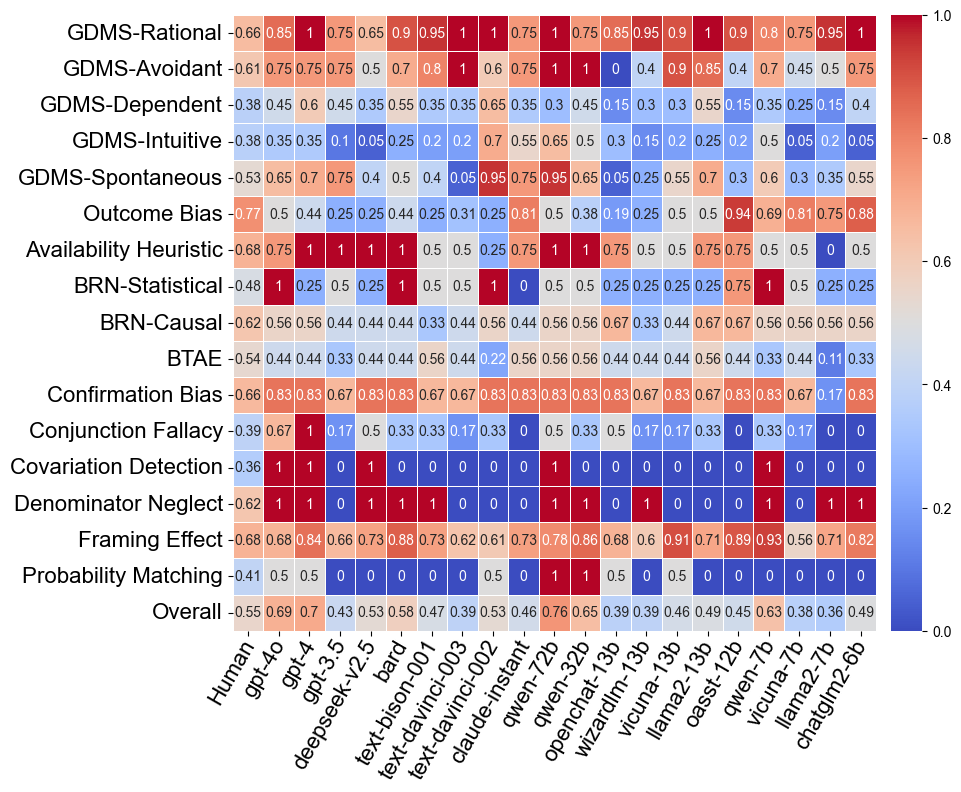

In [169]:
plt.figure(figsize=(10, 8))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')
plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'dec_orig.pdf'), bbox_inches='tight')
plt.show()

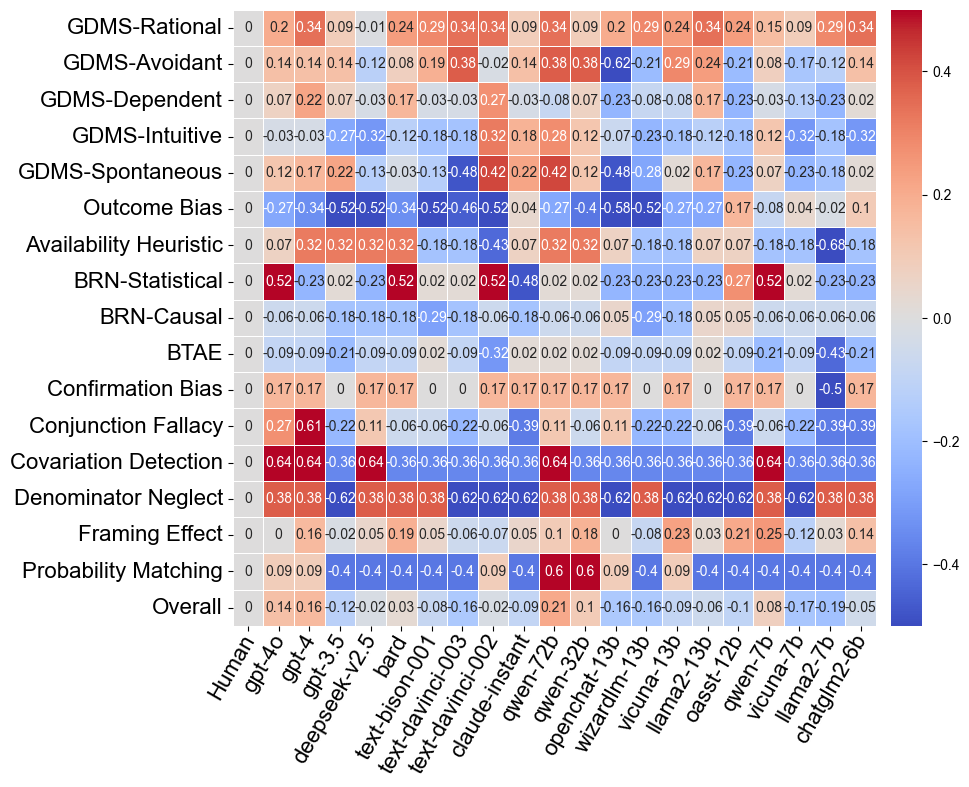

In [170]:
# plot difference with human
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
dfplot_2 = dfplot.copy()

plt.figure(figsize=(10, 8))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'dec_norm.pdf'), bbox_inches='tight')
plt.show()

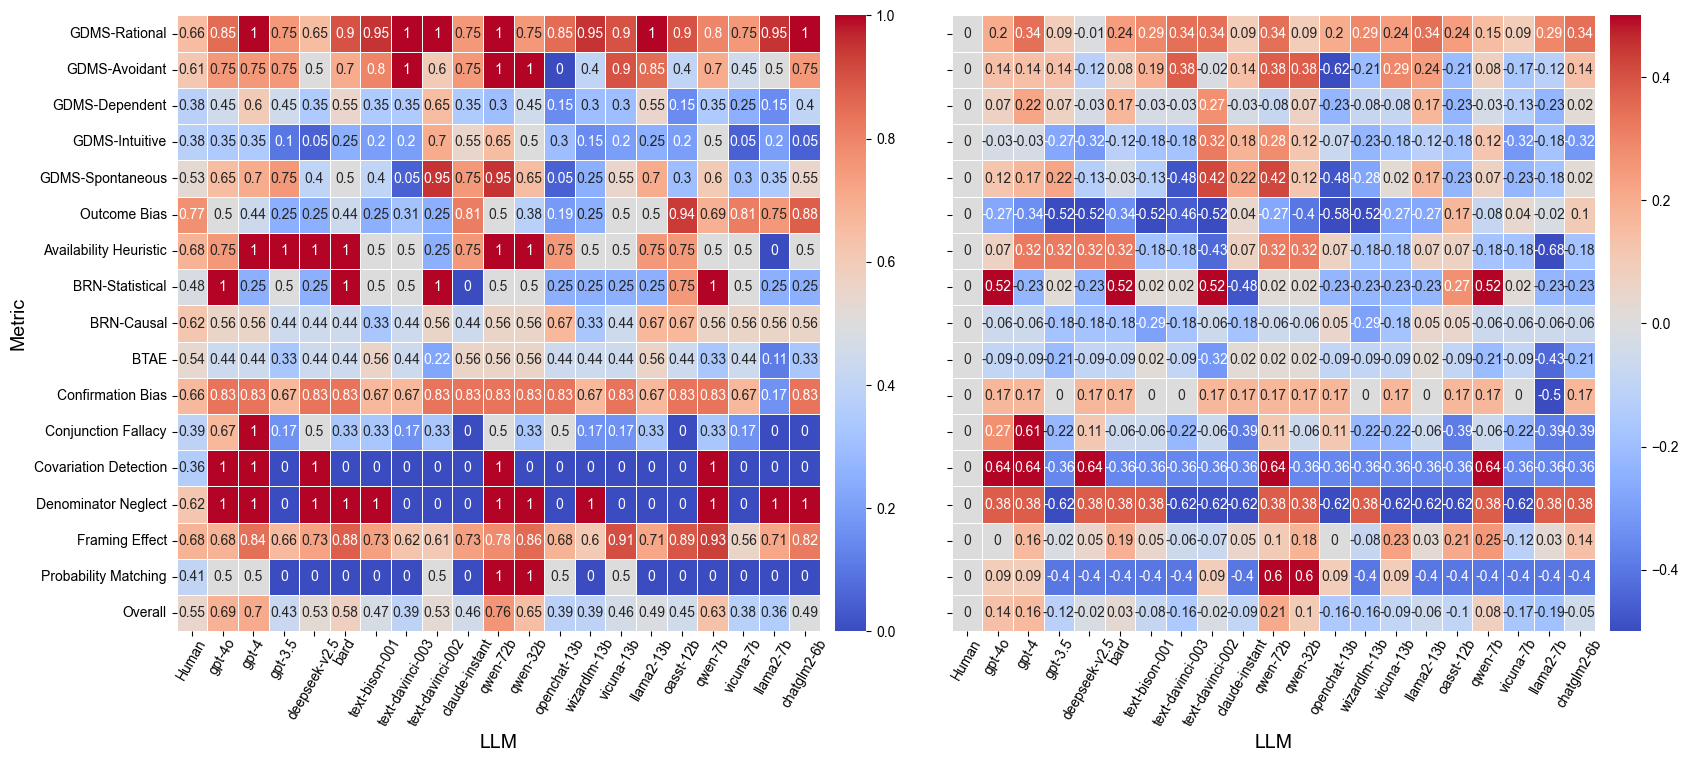

In [50]:

# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 创建一个1行2列的子图布局，并共享y轴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# # 在第一个子图上绘制dfplot的热力图
sns.heatmap(dfplot_1, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, 
            annot_kws={"size": 10}, ax=ax1, cbar_kws={"pad": 0.02})
# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot_1.columns))):
#     if j == 0:
#         ax1.add_patch(plt.Rectangle((j, 0), 1, len(dfplot_1.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = ax1.get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')

# 设置x轴刻度标签并倾斜
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='center')
ax1.tick_params(axis='x', which='major', pad=0)
cbar_ax1 = ax1.collections[0].colorbar
cbar_ax1.ax.set_position([ax1.get_position().x1 + 1, ax1.get_position().y0, 0.92, ax1.get_position().height])

# 在第二个子图上绘制dfplot1的热力图
sns.heatmap(dfplot_2, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, 
            annot_kws={"size": 10}, ax=ax2, cbar_kws={"pad": 0.02})
# 设置x轴刻度标签并倾斜
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='center')
ax2.tick_params(axis='x', which='major', pad=0)

# 设置标题和轴标签
# fig.suptitle('Decision Making', y=0.94, fontsize=16)  # 调整标题的位置
ax1.set_ylabel('Metric', fontsize=14)
ax1.set_xlabel('LLM', fontsize=14)
ax2.set_xlabel('LLM', fontsize=14)
ax2.set_ylabel('')  # 移除右图的y轴标签

plt.subplots_adjust(wspace=-0.0)  # 减少子图之间的间距
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以适应标题
plt.savefig(os.path.join(plotpath, 'dec.pdf'), bbox_inches='tight')
plt.show()


## Economics & Theoretical

In [56]:
selected_scales=[
            'Overconfidence',
            ]
selected_elements=[
             'Ethical','Financial','Health/Safety','Recreational','Social',
            'Risk Propensity Scale','Sunk Cost Fallacy']

# df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]
df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x: x['Scale'] in selected_scales,axis=1)]
df1

Concepts           Scale            name Scale Elements  \
122  Economics  Overconfidence  Overconfidence        Overall   

    Higher score & Ratonality Total/Average/Level gpt-4 gpt-3.5  \
122        Oppose Rationality        Average_bias  0.08     0.1   

    text-davinci-003 text-davinci-002 claude-instant text-bison-001  bard  \
122             0.33             0.14           0.07           0.04  0.07   

    chatglm2-6b llama2-13b llama2-7b vicuna-13b vicuna-7b openchat-13b  \
122        0.33       0.17      0.21       0.17      0.43         0.08   

    wizardlm-13b oasst-12b qwen-7b qwen-32b qwen-72b gpt-4o deepseek-v2.5  \
122         0.08      0.43    0.04     0.07     0.07   0.04          0.04   

      Human  Max_score  Min_score  Show  
122  0.1411        1.0        0.0     1

In [57]:
df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot

Human  gpt-4o  gpt-4  gpt-3.5  deepseek-v2.5  bard  \
name                                                                           
Overconfidence\nOverall  0.8589    0.96   0.92      0.9           0.96  0.93   
Overall                  0.8590    0.96   0.92      0.9           0.96  0.93   

                         text-bison-001  text-davinci-003  text-davinci-002  \
name                                                                          
Overconfidence\nOverall            0.96              0.67              0.86   
Overall                            0.96              0.67              0.86   

                         claude-instant  qwen-72b  qwen-32b  openchat-13b  \
name                                                                        
Overconfidence\nOverall            0.93      0.93      0.93          0.92   
Overall                            0.93      0.93      0.93          0.92   

                         wizardlm-13b  vicuna-13b  llama2-13b  oasst-12b  \
name                                                                       
Overconfidence\nOverall          0.92        0.83        0.83       0.57   
Overall                          0.92        0.83        0.83       0.57   

                         qwen-7b  vicuna-7b  llama2-7b  chatglm2-6b  
name                                                                 
Overconfidence\nOverall     0.96       0.57       0.79         0.67  
Overall                     0.96       0.57       0.79         0.67

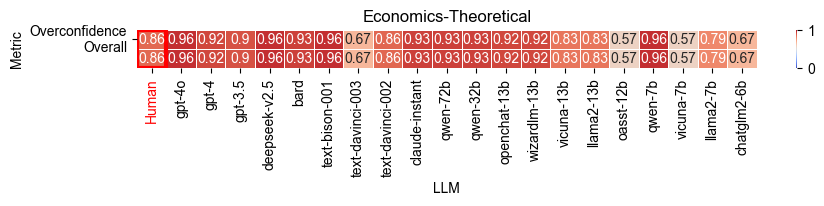

In [58]:
plt.figure(figsize=(10, 0.5))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1)

# 添加红色边框在第一列
for _, j in enumerate(range(len(dfplot.columns))):
    if j == 0:  # 检查是否是1st列
        plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# 将第一列的x轴刻度标签设置为红色
xticks_labels = plt.gca().get_xticklabels()
if xticks_labels:
    xticks_labels[0].set_color('red')
    
plt.yticks(rotation=0)
plt.title('Economics-Theoretical')
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()

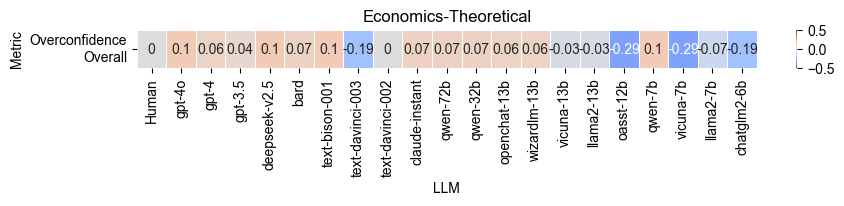

In [59]:
# plot difference with human
df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

dfplot=dfplot[col_order]

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
# dfplot

plt.figure(figsize=(10, 0.5))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5)

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')
    
plt.yticks(rotation=0)
plt.title('Economics-Theoretical')
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()

## Economics & Practical

In [60]:
selected_scales=[
            'Risk-Taking',
            'Risk-Perception',
            'Risk Propensity Scale',
    'Temporal Discounting',
    'Endowment Effect',
    "Gambler's Fallacy",
    'Loss Aversion',
    'Mental Accounting',
    'Regression to the Mean',
            'Sunk Cost Fallacy',
            ]
selected_elements=[
             'Ethical','Financial','Health/Safety','Recreational','Social',
            'Risk Propensity Scale','Sunk Cost Fallacy']

# df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]
df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x: x['Scale'] in selected_scales,axis=1)]
df1

Concepts                   Scale                  name  \
124  Risk-Perception             Risk-Taking            RT-Ethical   
127  Risk-Perception             Risk-Taking          RT-Financial   
130  Risk-Perception             Risk-Taking      RT-Health/Safety   
133  Risk-Perception             Risk-Taking       RT-Recreational   
136  Risk-Perception             Risk-Taking             RT-Social   
142  Risk-Perception         Risk-Perception            RP-Ethical   
145  Risk-Perception         Risk-Perception          RP-Financial   
148  Risk-Perception         Risk-Perception      RP-Health/Safety   
151  Risk-Perception         Risk-Perception       RP-Recreational   
154  Risk-Perception         Risk-Perception             RP-Social   
160  Risk-Perception   Risk Propensity Scale       Risk Propensity   
162  Risk-Perception           Loss Aversion         Loss Aversion   
163  Risk-Perception    Temporal Discounting  Temporal Discounting   
166  Risk-Perception        Endowment Effect      Endowment Effect   
167  Risk-Perception       Gambler's Fallacy     Gambler's Fallacy   
168  Risk-Perception       Mental Accounting     Mental Accounting   
169  Risk-Perception  Regression to the Mean                   RTM   
170  Risk-Perception       Sunk Cost Fallacy     Sunk Cost Fallacy   

    Scale Elements Higher score & Ratonality Total/Average/Level gpt-4  \
124        Ethical        Oppose Rationality       Average_score     1   
127      Financial        Oppose Rationality       Average_score  3.33   
130  Health/Safety        Oppose Rationality       Average_score  1.33   
133   Recreational        Oppose Rationality       Average_score  4.33   
136         Social        Oppose Rationality       Average_score   5.5   
142        Ethical       Support Rationality       Average_score     6   
145      Financial       Support Rationality       Average_score   4.5   
148  Health/Safety       Support Rationality       Average_score     6   
151   Recreational       Support Rationality       Average_score  4.83   
154         Social       Support Rationality       Average_score     3   
160        Overall       Support Rationality       Average_score     5   
162        Overall        Oppose Rationality       Average_score   0.5   
163        Overall       Support Rationality         Total_score    24   
166        Overall        Oppose Rationality           |WTA-WTP|     0   
167        Overall       Support Rationality         Total_score     9   
168        Overall        Oppose Rationality         Total_score     1   
169        Overall       Support Rationality  Single_score (0/1)     1   
170        Overall       Support Rationality       Average_score   4.2   

    gpt-3.5 text-davinci-003 text-davinci-002 claude-instant text-bison-001  \
124    1.33                1             1.83              1            1.5   
127    2.67              2.5             3.83           3.17           3.67   
130    1.83             2.17             2.83           2.83           2.33   
133     5.5             5.33                6           3.67           3.83   
136    6.67             5.83             4.83           5.83              5   
142    5.67             5.83             5.83           5.33           5.33   
145     5.5              5.5             4.83              5           4.67   
148     5.5             3.83              5.5              5           5.83   
151    5.33                4             5.83           5.33              5   
154    3.17              3.5             3.83            2.5              4   
160     3.2              5.8              2.2              6            5.4   
162       0                0                0              0            0.5   
163      14               15               18             17             17   
166     2.5              9.5              9.5           3.25            9.5   
167       4                6                5              6              6   
168       

In [61]:
df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot

Human    gpt-4o     gpt-4   gpt-3.5  \
name                                                                      
Risk-Taking\nEthical             0.666667  0.971667  1.000000  0.945000   
Risk-Taking\nFinancial           0.591667  0.583333  0.611667  0.721667   
Risk-Taking\nHealth/Safety       0.561667  0.945000  0.945000  0.861667   
Risk-Taking\nRecreational        0.526667  0.555000  0.445000  0.250000   
Risk-Taking\nSocial              0.266667  0.305000  0.250000  0.055000   
Risk-Perception\nEthical         0.575000  0.888333  0.833333  0.778333   
Risk-Perception\nFinancial       0.536667  0.638333  0.583333  0.750000   
Risk-Perception\nHealth/Safety   0.585000  0.916667  0.833333  0.750000   
Risk-Perception\nRecreational    0.551667  0.778333  0.638333  0.721667   
Risk-Perception\nSocial          0.290000  0.416667  0.333333  0.361667   
Risk Propensity Scale\nOverall   0.570000  0.800000  0.666667  0.366667   
Loss Aversion\nOverall           0.512000  1.000000  0.500000  1.000000   
Temporal Discounting\nOverall    0.512800  0.720000  0.760000  0.360000   
Endowment Effect\nOverall        0.475789  1.000000  1.000000  0.736842   
Gambler's Fallacy\nOverall       0.659000  0.900000  0.900000  0.400000   
Mental Accounting\nOverall       0.790000  0.000000  0.000000  0.000000   
Regression to the Mean\nOverall  0.400000  1.000000  1.000000  1.000000   
Sunk Cost Fallacy\nOverall       0.680000  0.780000  0.640000  0.660000   
Overall                          0.542000  0.733000  0.663000  0.595000   

                                 deepseek-v2.5      bard  text-bison-001  \
name                                                                       
Risk-Taking\nEthical                  0.971667  0.945000        0.916667   
Risk-Taking\nFinancial                0.528333  0.555000        0.555000   
Risk-Taking\nHealth/Safety            0.833333  0.833333        0.778333   
Risk-Taking\nRecreational             0.278333  0.583333        0.528333   
Risk-Taking\nSocial                   0.221667  0.195000        0.333333   
Risk-Perception\nEthical              0.861667  0.721667        0.721667   
Risk-Perception\nFinancial            0.750000  0.611667        0.611667   
Risk-Perception\nHealth/Safety        0.805000  0.750000        0.805000   
Risk-Perception\nRecreational         0.750000  0.778333        0.666667   
Risk-Perception\nSocial               0.416667  0.388333        0.500000   
Risk Propensity Scale\nOverall        0.366667  0.700000        0.733333   
Loss Aversion\nOverall                0.500000  0.500000        0.500000   
Temporal Discounting\nOverall         0.440000  0.440000        0.480000   
Endowment Effect\nOverall             1.000000  0.315789        0.000000   
Gambler's Fallacy\nOverall            0.800000  0.600000        0.600000   
Mental Accounting\nOverall            0.000000  0.000000        0.000000   
Regression to the Mean\nOverall       1.000000  1.000000        1.000000   
Sunk Cost Fallacy\nOverall            0.900000  0.660000        0.740000   
Overall                               0.635000  0.588000        0.582000   

                                 text-davinci-003  text-davinci-002  \
name                                                                  
Risk-Taking\nEthical                     1.000000          0.861667   
Risk-Taking\nFinancial                   0.750000          0.528333   
Risk-Taking\nHealth/Safety               0.805000          0.695000   
Risk-Taking\nRecreational                0.278333          0.166667   
Risk-Taking\nSocial                      0.195000          0.361667   
Risk-Perception\nEthical                 0.805000          0.805000   
Risk-Perception\nFinancial               0.750000          0.638333   
Risk-Perception\nHealth/Safety           0.471667          0.750000   
Risk-Perception\nRecreational            0.500000          0.805000   
Risk-Perception\nSocial                  0.416667          0.471667   
Risk Propen

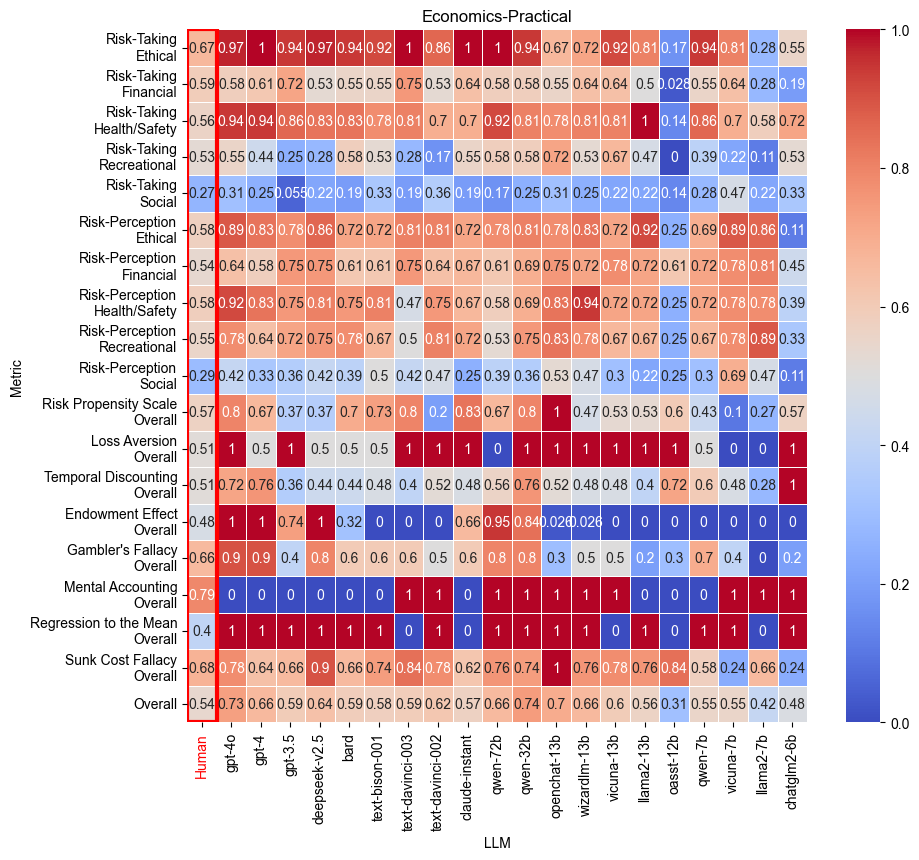

In [62]:
plt.figure(figsize=(10, 9))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1)

# 添加红色边框在第一列
for _, j in enumerate(range(len(dfplot.columns))):
    if j == 0:  # 检查是否是1st列
        plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# 将第一列的x轴刻度标签设置为红色
xticks_labels = plt.gca().get_xticklabels()
if xticks_labels:
    xticks_labels[0].set_color('red')
    
plt.title('Economics-Practical')
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()

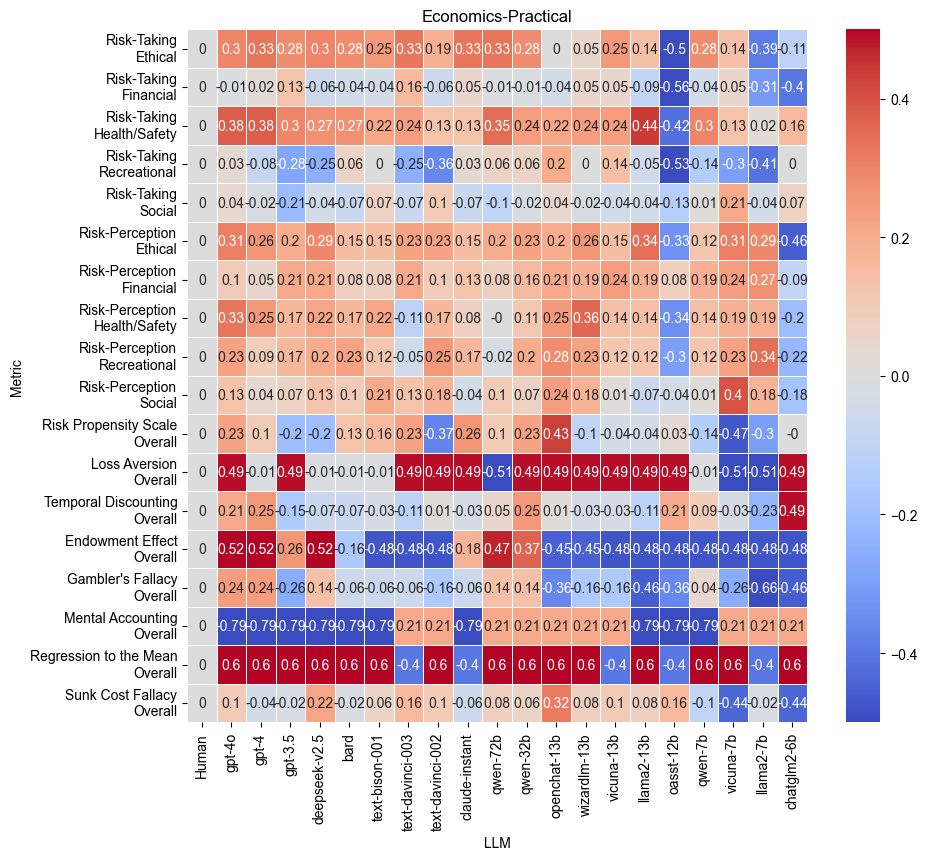

In [63]:
df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

dfplot=dfplot[col_order]

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
# dfplot

plt.figure(figsize=(10, 9))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5)

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')
    
plt.title('Economics-Practical')
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()

## Economics+Overall

In [171]:
selected_scales=[
            'Overconfidence',
            ]

tmp=[
            'Risk-Taking',
            'Risk-Perception',
            'Risk Propensity Scale',
    'Temporal Discounting',
    'Endowment Effect',
    "Gambler's Fallacy",
    'Loss Aversion',
    'Mental Accounting',
    'Regression to the Mean',
            'Sunk Cost Fallacy',
            ]
selected_scales.extend(tmp)


# df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]
df1=df[df.apply(lambda x:x['Show']==1,axis=1)]
df1=df1[df1.apply(lambda x: x['Scale'] in selected_scales,axis=1)]
# df1

In [172]:
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]
dfplot_1 = dfplot.copy()

In [116]:
dfplot

Human    gpt-4o     gpt-4   gpt-3.5  deepseek-v2.5  \
name                                                                          
Overconfidence        0.858900  0.960000  0.920000  0.900000       0.960000   
RT-Ethical            0.666667  0.971667  1.000000  0.945000       0.971667   
RT-Financial          0.591667  0.583333  0.611667  0.721667       0.528333   
RT-Health/Safety      0.561667  0.945000  0.945000  0.861667       0.833333   
RT-Recreational       0.526667  0.555000  0.445000  0.250000       0.278333   
RT-Social             0.266667  0.305000  0.250000  0.055000       0.221667   
RP-Ethical            0.575000  0.888333  0.833333  0.778333       0.861667   
RP-Financial          0.536667  0.638333  0.583333  0.750000       0.750000   
RP-Health/Safety      0.585000  0.916667  0.833333  0.750000       0.805000   
RP-Recreational       0.551667  0.778333  0.638333  0.721667       0.750000   
RP-Social             0.290000  0.416667  0.333333  0.361667       0.416667   
Risk Propensity       0.570000  0.800000  0.666667  0.366667       0.366667   
Loss Aversion         0.512000  1.000000  0.500000  1.000000       0.500000   
Temporal Discounting  0.512800  0.720000  0.760000  0.360000       0.440000   
Endowment Effect      0.475789  1.000000  1.000000  0.736842       1.000000   
Gambler's Fallacy     0.659000  0.900000  0.900000  0.400000       0.800000   
Mental Accounting     0.790000  0.000000  0.000000  0.000000       0.000000   
RTM                   0.400000  1.000000  1.000000  1.000000       1.000000   
Sunk Cost Fallacy     0.680000  0.780000  0.640000  0.660000       0.900000   
Overall               0.558000  0.745000  0.677000  0.612000       0.652000   

                          bard  text-bison-001  text-davinci-003  \
name                                                               
Overconfidence        0.930000        0.960000          0.670000   
RT-Ethical            0.945000        0.916667          1.000000   
RT-Financial          0.555000        0.555000          0.750000   
RT-Health/Safety      0.833333        0.778333          0.805000   
RT-Recreational       0.583333        0.528333          0.278333   
RT-Social             0.195000        0.333333          0.195000   
RP-Ethical            0.721667        0.721667          0.805000   
RP-Financial          0.611667        0.611667          0.750000   
RP-Health/Safety      0.750000        0.805000          0.471667   
RP-Recreational       0.778333        0.666667          0.500000   
RP-Social             0.388333        0.500000          0.416667   
Risk Propensity       0.700000        0.733333          0.800000   
Loss Aversion         0.500000        0.500000          1.000000   
Temporal Discounting  0.440000        0.480000          0.400000   
Endowment Effect      0.315789        0.000000          0.000000   
Gambler's Fallacy     0.600000        0.600000          0.600000   
Mental Accounting     0.000000        0.000000          1.000000   
RTM                   1.000000        1.000000          0.000000   
Sunk Cost Fallacy     0.660000        0.740000          0.840000   
Overall               0.606000        0.602000          0.594000   

                      text-davinci-002  claude-instant  qwen-72b  qwen-32b  \
name                                                                         
Overconfidence                0.860000        0.930000  0.930000  0.930000   
RT-Ethical                    0.861667        1.000000  1.000000  0.945000   
RT-Financial                  0.528333        0.638333  0.583333  0.583333   
RT-Health/Safety              0.695000        0.695000  0.916667  0.805000   
RT-Recreational               0.166667        0.555000  0.583333  0.583333   
RT-Social                     0.361667        0.195000  0.166667  0.250000   
RP-Ethical                    0.805000        0.721667  0.778333  0.805000   
RP-Financial                  0.638333        0.666667  0.611667  0.695000   
RP-Health

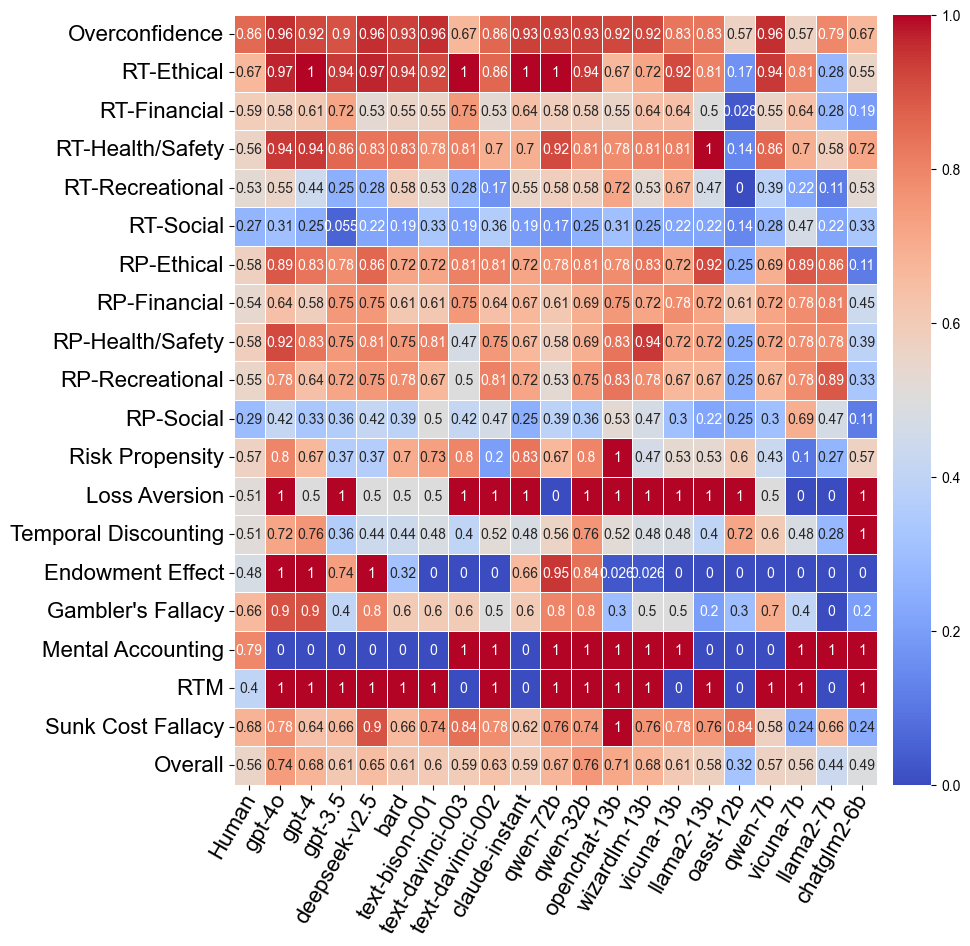

In [173]:
plt.figure(figsize=(10, 10))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot.columns))):
#     if j == 0:  # 检查是否是1st列
#         plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = plt.gca().get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')
    
plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'econ_orig.pdf'), bbox_inches='tight')
plt.show()

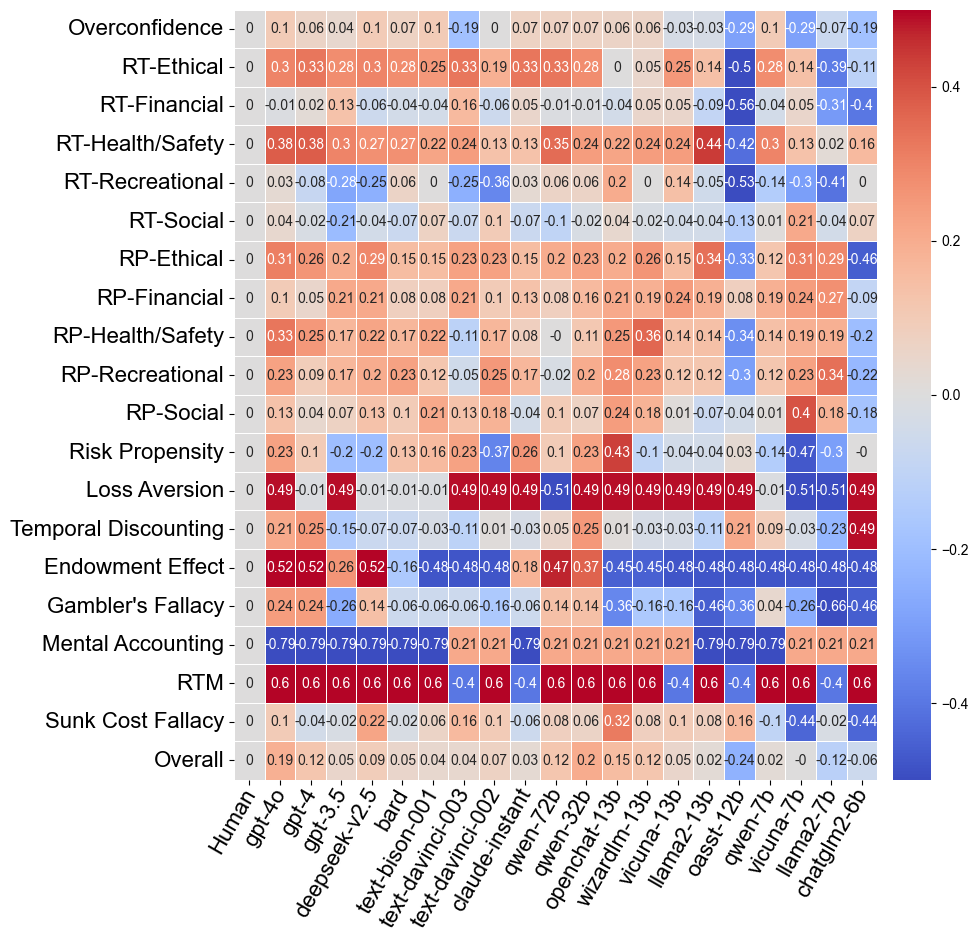

In [174]:
# plot difference with human
# df1['name']=df1['Scale']+'\n'+df1['Scale Elements']
reverse_names=df1[df1['Higher score & Ratonality']=='Oppose Rationality'].loc[:,'name']

dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

def normalize_row(row):
    m= row.loc['Min_score']
    M = row.loc['Max_score']
    return (row-m) / (M-m)

dfplot = dfplot.apply(normalize_row, axis=1)
dfplot=dfplot.drop(columns=['Max_score','Min_score'])
dfplot.loc[reverse_names]=1-dfplot.loc[reverse_names]

average_row = dfplot.mean().round(3)
dfplot.loc['Overall',:] = average_row

dfplot=dfplot[col_order]

dfplot = dfplot.apply(lambda x:x-x['Human'], axis=1).round(2)
dfplot_2 = dfplot.copy()

plt.figure(figsize=(10, 10))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, annot_kws={"size": 10},cbar_kws={"pad": 0.02})

plt.xticks(rotation=60, ha='right', fontsize=16)
plt.tick_params(axis='x', pad=0)  # 调整tick的距离
plt.yticks(fontsize=16)

ax = plt.gca()
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(10, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(plotpath, 'econ_norm.pdf'), bbox_inches='tight')
plt.show()

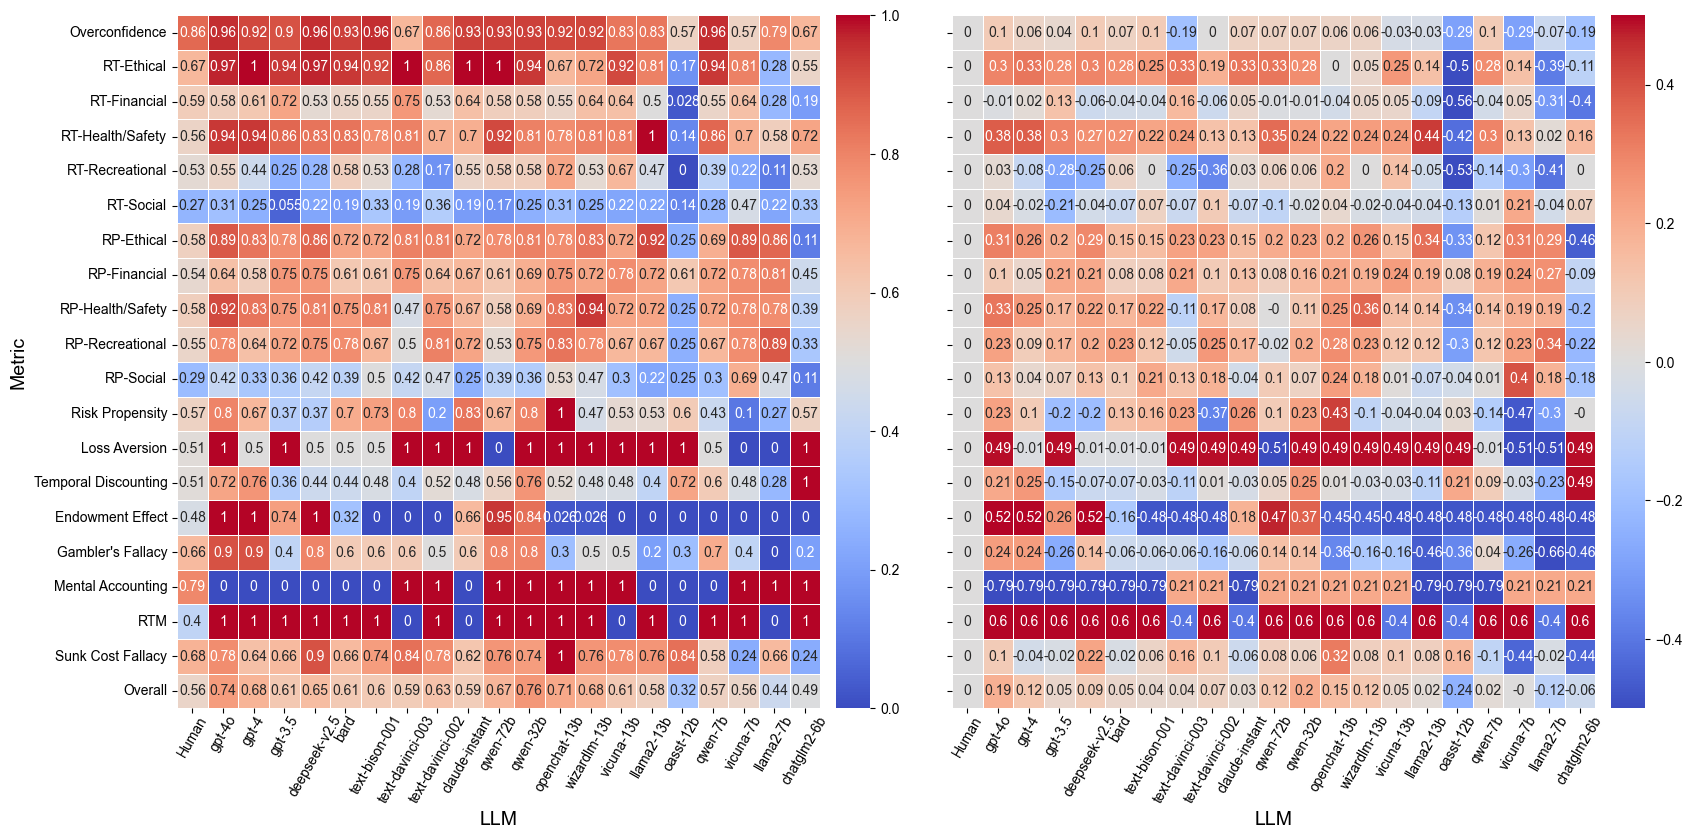

In [68]:

# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 创建一个1行2列的子图布局，并共享y轴
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), sharey=True)

# # 在第一个子图上绘制dfplot的热力图
sns.heatmap(dfplot_1, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1, 
            annot_kws={"size": 10}, ax=ax1, cbar_kws={"pad": 0.02})
# # 添加红色边框在第一列
# for _, j in enumerate(range(len(dfplot_1.columns))):
#     if j == 0:
#         ax1.add_patch(plt.Rectangle((j, 0), 1, len(dfplot_1.index), fill=False, edgecolor='red', lw=3))
# # 将第一列的x轴刻度标签设置为红色
# xticks_labels = ax1.get_xticklabels()
# if xticks_labels:
#     xticks_labels[0].set_color('red')

# 设置x轴刻度标签并倾斜
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='center')
ax1.tick_params(axis='x', which='major', pad=0)
cbar_ax1 = ax1.collections[0].colorbar
cbar_ax1.ax.set_position([ax1.get_position().x1 + 1, ax1.get_position().y0, 0.92, ax1.get_position().height])

# 在第二个子图上绘制dfplot1的热力图
sns.heatmap(dfplot_2, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-0.5, vmax=0.5, 
            annot_kws={"size": 10}, ax=ax2, cbar_kws={"pad": 0.02})
# 设置x轴刻度标签并倾斜
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='center')
ax2.tick_params(axis='x', which='major', pad=0)

# 设置标题和轴标签
# fig.suptitle('Economics', y=0.92, fontsize=16)  # 调整标题的位置
ax1.set_ylabel('Metric', fontsize=14)
ax1.set_xlabel('LLM', fontsize=14)
ax2.set_xlabel('LLM', fontsize=14)
ax2.set_ylabel('')  # 移除右图的y轴标签

plt.subplots_adjust(wspace=-0.0)  # 减少子图之间的间距
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以适应标题
plt.savefig(os.path.join(plotpath, 'econ.pdf'), bbox_inches='tight')
plt.show()


## Multi-modal

In [17]:

data = {'Human': 0.68, 'gpt-4': 0.68, 'bard': 0.59}
index = ['Image-based Scientific Reasoning Test']
col_order=['Human',
 'gpt-4',
'gpt-3.5',
'bard',
'text-bison-001',
'text-davinci-003',
'text-davinci-002',
'claude-instant',
'openchat-13b',
'wizardlm-13b',
'vicuna-13b',
'llama2-13b',
'oasst-12b',
'vicuna-7b',
'llama2-7b',
'chatglm2-6b',
]
dfplot = pd.DataFrame(columns=col_order)
dfplot.loc['Image-based Scientific Reasoning Test\nOverall'] = [data.get(col, None) for col in col_order]
dfplot

Human  gpt-4  gpt-3.5  bard  \
Image-based Scientific Reasoning Test\nOverall   0.68   0.68      NaN  0.59   

                                                text-bison-001  \
Image-based Scientific Reasoning Test\nOverall             NaN   

                                                text-davinci-003  \
Image-based Scientific Reasoning Test\nOverall               NaN   

                                                text-davinci-002  \
Image-based Scientific Reasoning Test\nOverall               NaN   

                                                claude-instant  openchat-13b  \
Image-based Scientific Reasoning Test\nOverall             NaN           NaN   

                                                wizardlm-13b  vicuna-13b  \
Image-based Scientific Reasoning Test\nOverall           NaN         NaN   

                                                llama2-13b  oasst-12b  \
Image-based Scientific Reasoning Test\nOverall         NaN        NaN   

                                                vicuna-7b  llama2-7b  \
Image-based Scientific Reasoning Test\nOverall        NaN        NaN   

                                                chatglm2-6b  
Image-based Scientific Reasoning Test\nOverall          NaN

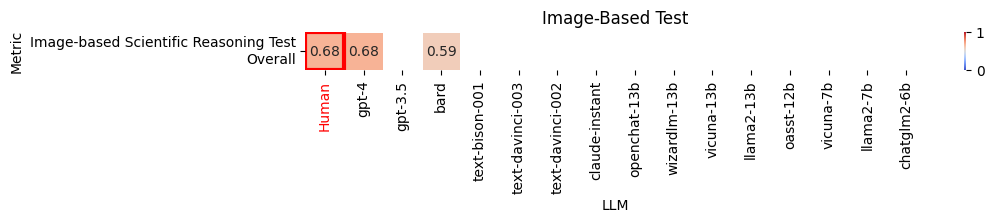

In [19]:
plt.figure(figsize=(10, 0.5))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5, vmin=0, vmax=1)

# 添加红色边框在第一列
for _, j in enumerate(range(len(dfplot.columns))):
    if j == 0:  # 检查是否是1st列
        plt.gca().add_patch(plt.Rectangle((j, 0), 1, len(dfplot.index), fill=False, edgecolor='red', lw=3))
# 将第一列的x轴刻度标签设置为红色
xticks_labels = plt.gca().get_xticklabels()
if xticks_labels:
    xticks_labels[0].set_color('red')
    
plt.title('Image-Based Test')
plt.yticks(rotation=0)
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()

# test

In [4]:
selected_elements=['Self-reflection (overall)','Insight','overall','Risk Propensity Scale',
            'Need for Cognition','Rationality (overall)',]

selected_scales=['self reflection and insight scale (SRIS)','Risk-Taking','Risk-Perception','Risk Propensity Scale','Emotion Regulation Questionnaire (ERQ)','Need for Cognition']

df1=df[df.apply(lambda x:x['Total/Average/Level'] not in ['Total_score','Level','Correct_number'],axis=1)]

df1=df1[df1.apply(lambda x:x['Scale Elements'] in selected_elements and x['Scale'] in selected_scales,axis=1)]
df1

Concepts                                     Scale  \
7        Self-Reflection  self reflection and insight scale (SRIS)   
10       Self-Reflection  self reflection and insight scale (SRIS)   
46       Risk-Perception                           Risk-Perception   
49       Risk-Perception                     Risk Propensity Scale   
58    Emotion Regulation    Emotion Regulation Questionnaire (ERQ)   
61  Intrinsic Motivation                        Need for Cognition   

               Scale Elements Higher score & Ratonality Total/Average/Level  \
7   Self-reflection (overall)       Support Rationality       Average_score   
10                    Insight       Support Rationality       Average_score   
46                    overall       Support Rationality       Average_score   
49      Risk Propensity Scale       Support Rationality       Average_score   
58                    overall       Support Rationality       Average_score   
61         Need for Cognition       Support Rationality       Average_score   

   gpt-4 gpt-3.5 text-davinci-003 text-davinci-002 claude-instant  \
7   5.25    5.08              5.5             4.92           4.92   
10  4.75     4.5                5             4.88           4.38   
46  4.87    5.03             4.53             5.17           4.63   
49     5     3.2              5.8              2.2              6   
58   4.8     4.6              6.6              5.8            4.4   
61  3.94    4.33             4.67             3.78           3.94   

   text-bison-001  bard chatglm2-6b llama2-13b llama2-7b vicuna-13b vicuna-7b  \
7            4.58  4.75        3.83       5.25       5.5       4.92      5.58   
10           2.62  4.62         3.5       4.88      2.38       4.62      4.12   
46           4.97   4.9        2.67        4.9      5.57       4.83       5.7   
49            5.4   5.2         4.4        4.2       2.6        4.2       1.6   
58            5.2     5         5.1        4.7       5.2        4.8       5.5   
61           4.61  4.11        4.28       4.28         4       3.94         4   

   openchat-13b wizardlm-13b oasst-12b  
7          5.42         5.33      5.33  
10         3.62         4.25      3.12  
46         5.47          5.5      2.93  
49            7          3.8       4.6  
58          6.1          6.2       5.1  
61         3.83         3.72       3.5

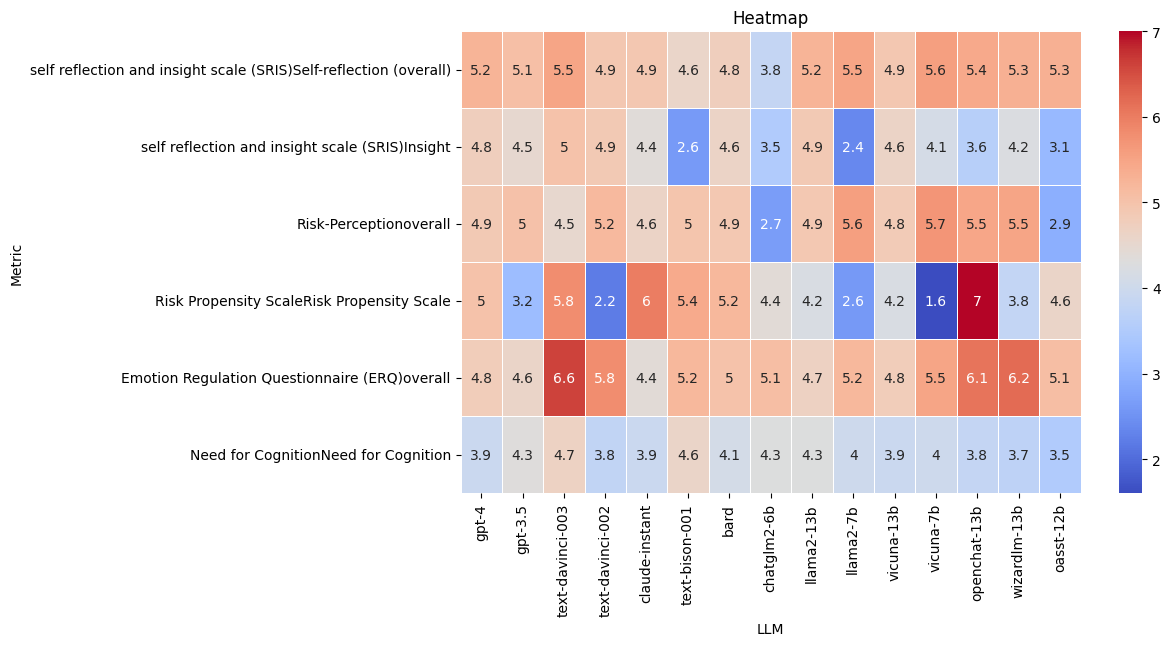

In [5]:
df1['name']=df1['Scale']+df1['Scale Elements']
dfplot=df1.drop(columns=['Concepts','Scale','Scale Elements','Higher score & Ratonality','Total/Average/Level'])

dfplot.set_index('name', inplace=True)
dfplot=dfplot.astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))

normalized_df = dfplot.copy()
normalized_df[dfplot.columns] = scaler.fit_transform(dfplot.T).T
# dfplot=normalized_df

# normalized_data = scaler.fit_transform(dfplot)
# dfplot = pd.DataFrame(normalized_data, columns=dfplot.columns, index=dfplot.index)

# 使用Seaborn绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(dfplot, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap')
plt.ylabel('Metric')
plt.xlabel('LLM')
plt.show()